In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from nltk.corpus import stopwords
import numpy as np
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
import string
import re
import burst_detection as bd
import warnings
import glob
from itertools import dropwhile
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pickle
import os.path

In [2]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)

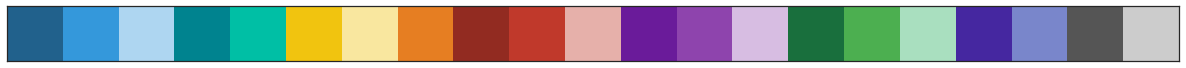

In [3]:
#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

In [4]:
#function to extract images stored in a df
def image_extract(x,file_name,n):
    x_sample = x.sample(n)
    img_urls = x_sample['image_url']
    for index, url in enumerate(img_urls):
        try:
            link = urlopen(url)
        except:
            print("Bad URL")
            continue
        try:
            name = "%s%s.jpg" % (file_name, (index+1))
            with open(name, "wb") as output:
                output.write(link.read())
        except IOError:
            print("Unable to create %s") % name

In [5]:
#word count function
def freq_dist(data, n_words):
    ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    return freq_distribution.most_common(n_words)

In [6]:
# read write pickles
def write_pickle(name, input_):
    '''
    name specifies where you want to write which file 
    input defines which variable you want to write as a pickle
    '''
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_out = pickle.dumps(input_)
    with open(name, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])
            

def read_pickle(name):
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_in = bytearray(0)
    input_size = os.path.getsize(name)
    with open(name, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    return pickle.loads(bytes_in)

In [ ]:
path = 'data'
allFiles = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))

## PreProcessing

In [ ]:
stop_word = set(stopwords.words('dutch'))
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
excludes = ['objecttype', 'file directory not found']

#df = df[~df['date'].str.contains('date')] #remove duplicate header rows
#df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
#df['date'] = df['date'].astype('datetime64[ns]') #convert dates 
#df = df.sort_values(by='date') #sort by dates
df['ocr_clean'] = df['ocr'].str.replace(regex_pat, '') #only keep words
df['ocr_clean'] = df['ocr_clean'].str.findall('\w{4,}').str.join(' ') #only keep words more than 3 chars
df['ocr_clean'] = df['ocr_clean'].str.lower().str.strip()
df['ocr_clean'] = df['ocr_clean'].str.strip()#lower and remove whitespaces
df['ocr_clean'] = [' '.join(filter(None,filter(lambda word: word not in stop_word, line))) for line in df['ocr_clean'].str.split(' ')]
df['words'] = df['ocr_clean'].apply(lambda x: x.lower().split())
#calculating proportion of characters relative to size of the advertisement. 
df['area'] = df['w'] * df['h']
df['string_length'] = df['ocr_clean'].str.len()
df['character_proportion'] = df['string_length'] / df ['area']
df = df[df['character_proportion'] < 10] #remove ads with lot of text (i.e. ocr errors)

df['publication_year'] = df['date'].apply(lambda x: x.year)
df['publication_month'] = df['date'].apply(lambda x: x.month)
df['publication_day'] = df['date'].apply(lambda x: x.day)

drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'ocr', 'area']
df.drop(drop_cols, axis=1, inplace=True)

# Read / Write Pickles

In [ ]:
write_pickle('ads.pkl', df)

In [ ]:
df = read_pickle('ads.pkl')

In [ ]:
car_brands = [
    r'\bopel\b',
    r'\brenault\b',
    r'\baudi\b',
    r'\bsimca\b',
    r'\bpeugeot\b',
    r'\bbuick\b',
    r'\bvolkswagen\b',
    r'\bford\b',
    r'\bStandard\b',
    r'\bTriumph\b',
    r'\bfiat\b',
    r'\bnissan\b',
    r'\bBMW\b',
    r'\bmercedes\b',
    r'\bporsche\b',
    r'\bdaewoo\b',
    r'\btoyota\b',
    r'\balfa romeo\b',
    r'\bsubaru\b',
    r'\bhonda\b',
    r'\blexus\b',
    r'\bmazda\b',
    r'\blada\b',
    r'\bhyundai\b',
    r'\bbentley\b',
    r'\bjaguar\b',
    r'\bcadillac\b',
    r'\bchevrolet\b',
    r'\bchrysler\b',
    r'\bjeep\b',
]

In [ ]:
car_df = df[df['ocr_clean'].str.contains('|'.join(car_brands))]
car_df = car_df[car_df['character_proportion'] < 0.00020] #car ads with image and text
car_df = ads_image.reset_index(drop=True)

In [7]:
#ads_image.to_pickle('ads_image.pkl')
car_df = pd.read_pickle('ads_image.pkl')

In [8]:
car_df['publication_year'] = car_df['date'].apply(lambda x: x.year)
car_df['publication_month'] = car_df['date'].apply(lambda x: x.month)
car_df['publication_day'] = car_df['date'].apply(lambda x: x.day)
car_df['words'] = car_df['ocr_clean'].apply(lambda x: x.lower().split())

In [ ]:
#ads_image_sample = ads_image.sample(frac=.25)
#image_extract(ads_image_sample, 'cars')

In [7]:
#parameters
min_df = 10

In [9]:
corpus = np.array(car_df['ocr_clean'])

In [10]:
#count the number of articles published each month
d = car_df.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)

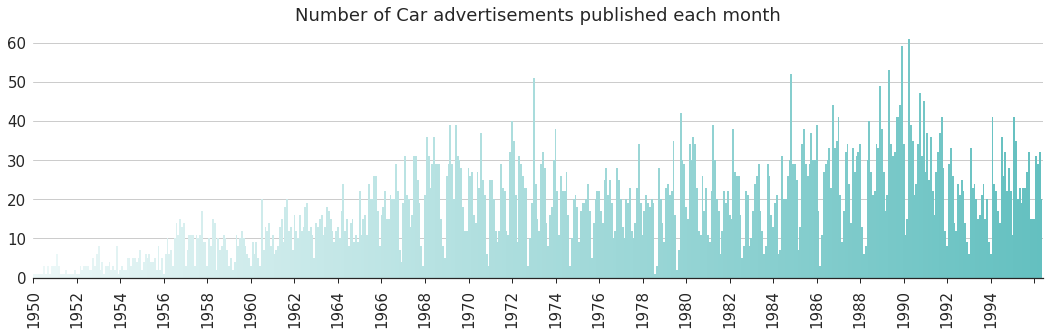

In [11]:
#plot the number of articles published each month
#initialize a figure
plt.figure(figsize=(15,5))
#plot bars
axes = plt.bar(d.index, d, width=1, color=blue_cmap(d.index.values/d.index.max()))  #color according to month

#format plot
plt.grid(axis='y')
plt.xlim(0,len(d))
plt.xticks(range(0,len(d),24), range(1950,1995,2), rotation=90)
plt.tick_params(axis='x', length=5)
plt.title('Number of Car advertisements published each month')
sns.despine(left=True)

plt.tight_layout()
plt.savefig('car_ads_per_month.png', dpi=300)

# Unique Words

In [ ]:
#trained on server

In [ ]:
# %load burstdetection.py
import pandas as pd
import burst_detection as bd
import numpy as np
from collections import Counter
from itertools import dropwhile

'''
script to find bursts in text
'''

def read_df():
    df = pd.read_pickle('ads_image.pkl')
    # df = df.sample(frac=0.001)
    df['words'] = df['ocr_clean'].apply(lambda x: x.lower().split())
    df['publication_year'] = df['date'].apply(lambda x: x.year)
    df['publication_month'] = df['date'].apply(lambda x: x.month)
    df['publication_day'] = df['date'].apply(lambda x: x.day)
    #drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h',
    #             'ocr', 'image_url']
    #df.drop(drop_cols, axis=1, inplace=True)
    print(df.shape)
    return df


def find_unique_words(data, threshold):
    # count all words
    word_counts = Counter(data['words'].apply(pd.Series).stack())
    print('Number of unique words: ', len(word_counts))

    for key, count in dropwhile(lambda x: x[1] >= threshold,
                                word_counts.most_common()):
                                del word_counts[key]
    print('Number of unique words with at least', threshold, 'occurances: ',
          len(word_counts))
    # create a list of unique words
    return list(word_counts.keys())


def word_proportions(df, word_list):
    '''
    create dataframe with word word_proportions
    '''
    time_frame = ['publication_year', 'publication_month']
    d = df.groupby(['publication_year', 'publication_month'])['words'].count().reset_index(drop=True)
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)],
                                axis=1).groupby(by=time_frame) \
                               .sum().reset_index(drop=True)
        if np.mod(i, 100) == 0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r, d


def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2   # resolution of state jumps; higher s --> fewer but stronger bursts
    gam = 0.5  # difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d)  # number of timepoints
    smooth_win = 5

    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])

    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)

        # find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r, d, n, s, gam, smooth_win)

        # enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)

        # find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)

        # add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)

        # print a progress report every 100 words
        if np.mod(i, 100) == 0:
            print('total words', len(word_list), 'word', i, 'complete')

    return all_bursts.sort_values(by='weight', ascending=False)


def main():
    threshold = 10
    df = read_df()
    unique_words = find_unique_words(df, threshold)
    all_r, d = word_proportions(df, unique_words)
    all_r.to_pickle('all_unique_words.pkl')
    bursts_unique = find_bursts(d, all_r, unique_words)
    bursts_unique.to_pickle('burst_unique.pkl')


if __name__ == "__main__":
    main()


# Chi-square

In [18]:
from sklearn.feature_selection import chi2

In [19]:
labels_decade = []
for index,row in car_df.iterrows():
    if row['publication_year'] < 1950:
        labels_decade.append('1940')
    elif row['publication_year'] > 1949 & row['publication_year'] < 1960:
        labels_decade.append('1950')
    elif row['publication_year'] > 1959 & row['publication_year'] < 1970:
        labels_decade.append('1960')
    elif row['publication_year'] > 1969 & row['publication_year'] < 1980:
        labels_decade.append('1970')
    elif row['publication_year'] > 1979 & row['publication_year'] < 1990:
        labels_decade.append('1980')
    elif row['publication_year'] > 1989 & row['publication_year'] < 1999:
        labels_decade.append('1990')   

In [20]:
labels = []
for index,row in car_df.iterrows():
    labels.append(row['publication_year'])   

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(car_df['ocr_clean'])
vocab = np.array(vectorizer.get_feature_names())
#dtm = dtm.toarray()

In [27]:
keyness, _ = chi2(dtm, labels)
ranking = np.argsort(keyness)[::-1]

keyness, _ = chi2(dtm, labels_decade)
ranking2 = np.argsort(keyness)[::-1]

In [28]:
chi_words = vocab[ranking]
chi_words_decade = vocab[ranking2]

# TF-IDF words

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm='l1', sublinear_tf=True, analyzer='word', lowercase=True, max_df = 0.1, min_df = min_df)
tfidf_matrix =  vectorizer.fit_transform(corpus)
scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
feature_list = []
tf_idf_words = []
for item in sorted_scores:
    feature_list.append({'word': item[0], 'score': item[1]})
    tf_idf_words.append(item[0])
features = pd.DataFrame(feature_list)

## Gensim Topic Modeling

In [22]:
from nltk import word_tokenize
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [14]:
docs = np.array(car_df['ocr_clean'])
docs = [document.split() for document in docs]

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=.1) #very strict pruning similar to tf-idf pruning
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

2018-04-18 13:18:32,951 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-18 13:18:34,430 : INFO : built Dictionary(210809 unique tokens: ['ford', 'nederla', 'voedselvoorziening', 'wederopbouw', 'aangesteld']...) from 9863 documents (total 1111173 corpus positions)
2018-04-18 13:18:34,722 : INFO : discarding 201807 tokens: [('ford', 1693), ('voedselvoorziening', 1), ('wederopbouw', 3), ('aarom', 4), ('amiler', 1), ('amsterdam', 2540), ('aners', 2), ('bedreven', 1), ('drura', 1), ('dusverre', 1)]...
2018-04-18 13:18:34,723 : INFO : keeping 9002 tokens which were in no less than 10 and no more than 986 (=10.0%) documents
2018-04-18 13:18:34,783 : INFO : resulting dictionary: Dictionary(9002 unique tokens: ['nederla', 'aangesteld', 'amsterdamsche', 'automobiel', 'automobilisten']...)


Number of unique tokens: 9002
Number of documents: 9863


In [40]:
# Train LDA model.

from gensim.models import LdaModel, LdaMulticore
from multiprocessing import cpu_count

# Set training parameters.
num_topics = 20
#chunksize = 2000
passes = 20
iterations = 500
eval_every = 5  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics,passes=passes, eval_every=eval_every)
#%time model = LdaMulticore(corpus=corpus, id2word=id2word, eta='auto', workers=cpu_count()-1, iterations=iterations, num_topics=num_topics,passes=passes, eval_every=eval_every)

2018-04-18 14:59:15,152 : INFO : using autotuned alpha, starting with [0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001]
2018-04-18 14:59:15,156 : INFO : using serial LDA version on this node
2018-04-18 14:59:16,017 : INFO : running online (multi-pass) LDA training, 20 topics, 20 passes over the supplied corpus of 9863 documents, updating model once every 2000 documents, evaluating perplexity every 9863 documents, iterating 500x with a convergence threshold of 0.001000
2018-04-18 14:59:16,024 : INFO : PROGRESS: pass 0, at document #2000/9863
2018-04-18 14:59:24,564 : INFO : optimized alpha [0.04251942, 0.042966574, 0.041844498, 0.042419158, 0.041744474, 0.04196725, 0.042176157, 0.040939927, 0.041949332, 0.042927369, 0.041900352, 0.042372737, 0.042507503, 0.041392103, 0.042577583,

2018-04-18 14:59:46,539 : INFO : topic #6 (0.055): 0.031*"mazda" + 0.026*"verstelbare" + 0.020*"toerenteller" + 0.016*"glas" + 0.012*"centrale" + 0.011*"neerklapbare" + 0.011*"telefoon" + 0.010*"veetra" + 0.010*"bumpers" + 0.010*"bestuurdersstoel"
2018-04-18 14:59:46,540 : INFO : topic #0 (0.076): 0.011*"komfort" + 0.007*"onze" + 0.007*"passat" + 0.006*"afgebeeld" + 0.005*"seat" + 0.005*"premie" + 0.005*"geregelde" + 0.005*"betaalt" + 0.005*"stuurbekrachtiging" + 0.005*"volkswagen"
2018-04-18 14:59:46,542 : INFO : topic #10 (0.081): 0.026*"getint" + 0.023*"binnenuit" + 0.013*"rente" + 0.012*"zolang" + 0.010*"glas" + 0.007*"omega" + 0.007*"maanden" + 0.007*"basis" + 0.007*"voorraad" + 0.007*"rover"
2018-04-18 14:59:46,543 : INFO : topic #16 (0.082): 0.015*"excl" + 0.008*"schone" + 0.007*"komplete" + 0.006*"injectiemotor" + 0.006*"versie" + 0.006*"bent" + 0.005*"gratis" + 0.003*"benzine" + 0.003*"verstelbare" + 0.003*"centrale"
2018-04-18 14:59:46,544 : INFO : topic diff=1.128253, rho=0.

2018-04-18 15:00:06,013 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:00:06,108 : INFO : topic #7 (0.049): 0.049*"nissan" + 0.020*"micra" + 0.016*"simca" + 0.013*"jubilee" + 0.013*"feest" + 0.012*"sail" + 0.011*"sunny" + 0.008*"datsun" + 0.008*"full" + 0.006*"autogas"
2018-04-18 15:00:06,109 : INFO : topic #2 (0.060): 0.065*"honda" + 0.031*"civic" + 0.030*"ohra" + 0.018*"accord" + 0.012*"schade" + 0.012*"ridderkerk" + 0.008*"gratis" + 0.008*"korting" + 0.005*"bies" + 0.005*"hondadealer"
2018-04-18 15:00:06,110 : INFO : topic #5 (0.104): 0.020*"gids" + 0.007*"omega" + 0.007*"techniek" + 0.006*"interieur" + 0.006*"flfl" + 0.006*"opeldealer" + 0.006*"kadett" + 0.006*"deur" + 0.005*"doorroesten" + 0.005*"kiezen"
2018-04-18 15:00:06,112 : INFO : topic #10 (0.111): 0.026*"getint" + 0.023*"binnenuit" + 0.013*"zolang" + 0.011*"rente" + 0.010*"voorraad" + 0.009*"aanbod" + 0.008*"maanden" + 0.008*"basis" + 0.008*"kleppen" + 0.007*"rover"
2018-04-18 15:

2018-04-18 15:00:23,920 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:00:23,992 : INFO : topic #7 (0.052): 0.052*"nissan" + 0.022*"simca" + 0.021*"micra" + 0.015*"sail" + 0.014*"jubilee" + 0.013*"feest" + 0.012*"sunny" + 0.011*"datsun" + 0.007*"full" + 0.006*"autogas"
2018-04-18 15:00:23,993 : INFO : topic #2 (0.063): 0.069*"honda" + 0.039*"ohra" + 0.032*"civic" + 0.019*"accord" + 0.013*"schade" + 0.012*"ridderkerk" + 0.011*"korting" + 0.009*"gratis" + 0.007*"eigen" + 0.007*"claim"
2018-04-18 15:00:23,994 : INFO : topic #5 (0.135): 0.018*"gids" + 0.009*"omega" + 0.008*"techniek" + 0.006*"interieur" + 0.006*"opeldealer" + 0.006*"flfl" + 0.006*"deur" + 0.006*"doorroesten" + 0.005*"kadett" + 0.005*"motoren"
2018-04-18 15:00:23,996 : INFO : topic #10 (0.138): 0.027*"getint" + 0.024*"binnenuit" + 0.013*"zolang" + 0.012*"voorraad" + 0.010*"aanbod" + 0.010*"kleppen" + 0.009*"basis" + 0.008*"rente" + 0.008*"rover" + 0.008*"maanden"
2018-04-18 15:00:2

2018-04-18 15:00:41,284 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:00:41,347 : INFO : topic #7 (0.054): 0.054*"nissan" + 0.029*"simca" + 0.022*"micra" + 0.015*"sail" + 0.014*"jubilee" + 0.014*"feest" + 0.012*"datsun" + 0.012*"sunny" + 0.007*"nieuw" + 0.007*"full"
2018-04-18 15:00:41,348 : INFO : topic #2 (0.066): 0.072*"honda" + 0.042*"ohra" + 0.034*"civic" + 0.019*"accord" + 0.014*"schade" + 0.013*"korting" + 0.013*"ridderkerk" + 0.011*"eigen" + 0.010*"gratis" + 0.009*"claim"
2018-04-18 15:00:41,349 : INFO : topic #18 (0.162): 0.018*"voordeel" + 0.013*"panda" + 0.011*"betaalt" + 0.011*"buitenspiegels" + 0.010*"tijdelijk" + 0.010*"maanden" + 0.010*"rente" + 0.009*"bedrag" + 0.009*"gulden" + 0.009*"betalen"
2018-04-18 15:00:41,350 : INFO : topic #5 (0.167): 0.018*"gids" + 0.009*"omega" + 0.008*"techniek" + 0.006*"interieur" + 0.006*"opeldealer" + 0.006*"motoren" + 0.006*"flfl" + 0.006*"doorroesten" + 0.006*"deur" + 0.005*"vormgeving"
2018-0

2018-04-18 15:00:58,604 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:00:58,661 : INFO : topic #7 (0.057): 0.054*"nissan" + 0.037*"simca" + 0.022*"micra" + 0.016*"sail" + 0.014*"feest" + 0.014*"jubilee" + 0.013*"datsun" + 0.012*"sunny" + 0.008*"cortina" + 0.008*"nieuw"
2018-04-18 15:00:58,662 : INFO : topic #2 (0.069): 0.074*"honda" + 0.044*"ohra" + 0.035*"civic" + 0.020*"accord" + 0.014*"schade" + 0.014*"eigen" + 0.013*"korting" + 0.013*"ridderkerk" + 0.010*"gratis" + 0.010*"claim"
2018-04-18 15:00:58,663 : INFO : topic #18 (0.187): 0.021*"voordeel" + 0.013*"panda" + 0.012*"maanden" + 0.012*"betaalt" + 0.012*"rente" + 0.011*"tijdelijk" + 0.010*"buitenspiegels" + 0.010*"gulden" + 0.009*"bedrag" + 0.009*"betalen"
2018-04-18 15:00:58,665 : INFO : topic #5 (0.199): 0.017*"gids" + 0.009*"omega" + 0.009*"techniek" + 0.007*"interieur" + 0.007*"motoren" + 0.006*"opeldealer" + 0.006*"vormgeving" + 0.006*"doorroesten" + 0.006*"deur" + 0.006*"flfl"
201

2018-04-18 15:01:16,619 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:01:16,673 : INFO : topic #7 (0.060): 0.054*"nissan" + 0.047*"simca" + 0.022*"micra" + 0.015*"sail" + 0.014*"feest" + 0.014*"datsun" + 0.014*"jubilee" + 0.012*"sunny" + 0.010*"cortina" + 0.009*"nieuw"
2018-04-18 15:01:16,674 : INFO : topic #2 (0.071): 0.076*"honda" + 0.046*"ohra" + 0.035*"civic" + 0.020*"accord" + 0.015*"eigen" + 0.015*"schade" + 0.014*"korting" + 0.013*"ridderkerk" + 0.010*"claim" + 0.010*"gratis"
2018-04-18 15:01:16,675 : INFO : topic #18 (0.208): 0.022*"voordeel" + 0.014*"panda" + 0.013*"maanden" + 0.012*"rente" + 0.012*"betaalt" + 0.011*"tijdelijk" + 0.010*"gulden" + 0.010*"buitenspiegels" + 0.009*"bedrag" + 0.009*"betalen"
2018-04-18 15:01:16,676 : INFO : topic #5 (0.229): 0.016*"gids" + 0.009*"omega" + 0.009*"techniek" + 0.007*"motoren" + 0.007*"interieur" + 0.006*"vormgeving" + 0.006*"opeldealer" + 0.006*"doorroesten" + 0.006*"deur" + 0.005*"flfl"
201

2018-04-18 15:01:33,233 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:01:33,278 : INFO : topic #7 (0.064): 0.058*"simca" + 0.054*"nissan" + 0.022*"micra" + 0.015*"sail" + 0.015*"datsun" + 0.014*"feest" + 0.014*"jubilee" + 0.012*"sunny" + 0.011*"cortina" + 0.009*"nieuw"
2018-04-18 15:01:33,279 : INFO : topic #2 (0.073): 0.078*"honda" + 0.047*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.017*"eigen" + 0.015*"schade" + 0.015*"korting" + 0.013*"ridderkerk" + 0.011*"claim" + 0.011*"gratis"
2018-04-18 15:01:33,280 : INFO : topic #18 (0.226): 0.023*"voordeel" + 0.014*"panda" + 0.014*"maanden" + 0.013*"rente" + 0.012*"betaalt" + 0.011*"tijdelijk" + 0.011*"gulden" + 0.010*"betalen" + 0.010*"buitenspiegels" + 0.010*"bedrag"
2018-04-18 15:01:33,282 : INFO : topic #5 (0.258): 0.016*"gids" + 0.009*"techniek" + 0.009*"omega" + 0.008*"motoren" + 0.007*"interieur" + 0.006*"vormgeving" + 0.006*"opeldealer" + 0.006*"deur" + 0.006*"doorroesten" + 0.005*"flfl"
201

2018-04-18 15:01:48,909 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:01:48,950 : INFO : topic #7 (0.067): 0.067*"simca" + 0.053*"nissan" + 0.022*"micra" + 0.015*"datsun" + 0.015*"sail" + 0.014*"feest" + 0.013*"jubilee" + 0.012*"sunny" + 0.011*"cortina" + 0.009*"nieuw"
2018-04-18 15:01:48,951 : INFO : topic #2 (0.076): 0.078*"honda" + 0.047*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.017*"eigen" + 0.016*"schade" + 0.015*"korting" + 0.013*"ridderkerk" + 0.011*"claim" + 0.011*"gratis"
2018-04-18 15:01:48,952 : INFO : topic #18 (0.240): 0.023*"voordeel" + 0.014*"maanden" + 0.014*"panda" + 0.013*"rente" + 0.012*"betaalt" + 0.011*"tijdelijk" + 0.011*"gulden" + 0.010*"betalen" + 0.010*"gratis" + 0.010*"bedrag"
2018-04-18 15:01:48,954 : INFO : topic #5 (0.285): 0.015*"gids" + 0.009*"techniek" + 0.009*"omega" + 0.008*"motoren" + 0.007*"interieur" + 0.006*"vormgeving" + 0.005*"deur" + 0.005*"doorroesten" + 0.005*"flfl" + 0.005*"opeldealer"
2018-04-18 

2018-04-18 15:02:04,346 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:02:04,386 : INFO : topic #7 (0.070): 0.075*"simca" + 0.053*"nissan" + 0.022*"micra" + 0.016*"datsun" + 0.015*"sail" + 0.014*"feest" + 0.013*"jubilee" + 0.012*"cortina" + 0.012*"sunny" + 0.009*"dealers"
2018-04-18 15:02:04,388 : INFO : topic #2 (0.078): 0.079*"honda" + 0.048*"ohra" + 0.036*"civic" + 0.021*"accord" + 0.018*"eigen" + 0.016*"schade" + 0.016*"korting" + 0.013*"ridderkerk" + 0.011*"claim" + 0.011*"gratis"
2018-04-18 15:02:04,390 : INFO : topic #18 (0.254): 0.024*"voordeel" + 0.014*"maanden" + 0.014*"panda" + 0.013*"rente" + 0.012*"betaalt" + 0.012*"tijdelijk" + 0.011*"gulden" + 0.010*"betalen" + 0.010*"gratis" + 0.010*"bedrag"
2018-04-18 15:02:04,391 : INFO : topic #5 (0.314): 0.015*"gids" + 0.009*"techniek" + 0.008*"motoren" + 0.008*"omega" + 0.007*"interieur" + 0.006*"vormgeving" + 0.006*"prestaties" + 0.005*"deur" + 0.005*"flfl" + 0.005*"hoge"
2018-04-18 15:02

2018-04-18 15:02:19,959 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:02:19,996 : INFO : topic #7 (0.073): 0.080*"simca" + 0.053*"nissan" + 0.021*"micra" + 0.016*"datsun" + 0.015*"sail" + 0.014*"feest" + 0.013*"jubilee" + 0.012*"cortina" + 0.012*"sunny" + 0.009*"dealers"
2018-04-18 15:02:19,997 : INFO : topic #2 (0.080): 0.080*"honda" + 0.048*"ohra" + 0.036*"civic" + 0.021*"accord" + 0.018*"eigen" + 0.016*"korting" + 0.016*"schade" + 0.014*"ridderkerk" + 0.012*"claim" + 0.011*"gratis"
2018-04-18 15:02:19,998 : INFO : topic #0 (0.269): 0.021*"volkswagen" + 0.016*"golf" + 0.013*"komfort" + 0.011*"onze" + 0.009*"polo" + 0.008*"bijvoorbeeld" + 0.008*"passat" + 0.007*"katalysator" + 0.007*"seat" + 0.007*"ascona"
2018-04-18 15:02:19,999 : INFO : topic #5 (0.342): 0.014*"gids" + 0.009*"techniek" + 0.009*"motoren" + 0.008*"omega" + 0.007*"interieur" + 0.006*"prestaties" + 0.006*"vormgeving" + 0.006*"nieuw" + 0.005*"deur" + 0.005*"hoge"
2018-04-18 15:

2018-04-18 15:02:35,033 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:02:35,070 : INFO : topic #7 (0.076): 0.084*"simca" + 0.052*"nissan" + 0.021*"micra" + 0.016*"datsun" + 0.014*"sail" + 0.014*"feest" + 0.013*"jubilee" + 0.013*"cortina" + 0.012*"sunny" + 0.009*"dealers"
2018-04-18 15:02:35,071 : INFO : topic #2 (0.082): 0.080*"honda" + 0.049*"ohra" + 0.036*"civic" + 0.021*"accord" + 0.019*"eigen" + 0.017*"korting" + 0.016*"schade" + 0.014*"ridderkerk" + 0.012*"claim" + 0.011*"gratis"
2018-04-18 15:02:35,072 : INFO : topic #0 (0.284): 0.021*"volkswagen" + 0.015*"golf" + 0.013*"komfort" + 0.011*"onze" + 0.009*"polo" + 0.008*"bijvoorbeeld" + 0.008*"passat" + 0.008*"katalysator" + 0.007*"seat" + 0.007*"ascona"
2018-04-18 15:02:35,073 : INFO : topic #5 (0.370): 0.014*"gids" + 0.009*"techniek" + 0.009*"motoren" + 0.008*"omega" + 0.007*"interieur" + 0.006*"prestaties" + 0.006*"nieuw" + 0.006*"vormgeving" + 0.005*"hoge" + 0.005*"deur"
2018-04-18 15:

2018-04-18 15:02:50,026 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:02:50,062 : INFO : topic #7 (0.078): 0.087*"simca" + 0.052*"nissan" + 0.021*"micra" + 0.017*"datsun" + 0.014*"sail" + 0.014*"feest" + 0.013*"cortina" + 0.013*"jubilee" + 0.011*"sunny" + 0.009*"dealers"
2018-04-18 15:02:50,063 : INFO : topic #2 (0.083): 0.080*"honda" + 0.049*"ohra" + 0.036*"civic" + 0.021*"accord" + 0.019*"eigen" + 0.017*"korting" + 0.016*"schade" + 0.014*"ridderkerk" + 0.012*"claim" + 0.011*"gratis"
2018-04-18 15:02:50,064 : INFO : topic #0 (0.298): 0.021*"volkswagen" + 0.015*"golf" + 0.013*"komfort" + 0.011*"onze" + 0.009*"polo" + 0.008*"bijvoorbeeld" + 0.008*"passat" + 0.008*"katalysator" + 0.007*"ascona" + 0.007*"seat"
2018-04-18 15:02:50,065 : INFO : topic #5 (0.398): 0.014*"gids" + 0.009*"techniek" + 0.009*"motoren" + 0.008*"omega" + 0.007*"interieur" + 0.007*"prestaties" + 0.006*"nieuw" + 0.006*"vormgeving" + 0.006*"hoge" + 0.005*"deur"
2018-04-18 15:

2018-04-18 15:03:04,720 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:03:04,752 : INFO : topic #7 (0.081): 0.090*"simca" + 0.052*"nissan" + 0.021*"micra" + 0.017*"datsun" + 0.014*"sail" + 0.014*"feest" + 0.013*"cortina" + 0.013*"jubilee" + 0.011*"sunny" + 0.009*"dealers"
2018-04-18 15:03:04,753 : INFO : topic #2 (0.085): 0.080*"honda" + 0.049*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.019*"eigen" + 0.017*"korting" + 0.017*"schade" + 0.014*"ridderkerk" + 0.012*"claim" + 0.011*"gratis"
2018-04-18 15:03:04,754 : INFO : topic #0 (0.312): 0.021*"volkswagen" + 0.015*"golf" + 0.013*"komfort" + 0.011*"onze" + 0.009*"polo" + 0.008*"bijvoorbeeld" + 0.008*"passat" + 0.008*"katalysator" + 0.007*"ascona" + 0.007*"seat"
2018-04-18 15:03:04,755 : INFO : topic #5 (0.426): 0.014*"gids" + 0.009*"techniek" + 0.009*"motoren" + 0.008*"omega" + 0.008*"interieur" + 0.007*"prestaties" + 0.006*"nieuw" + 0.006*"vormgeving" + 0.006*"hoge" + 0.005*"deur"
2018-04-18 15:

2018-04-18 15:03:19,222 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:03:19,253 : INFO : topic #7 (0.083): 0.093*"simca" + 0.051*"nissan" + 0.021*"micra" + 0.017*"datsun" + 0.014*"sail" + 0.014*"feest" + 0.013*"cortina" + 0.013*"jubilee" + 0.011*"sunny" + 0.009*"kunstleer"
2018-04-18 15:03:19,254 : INFO : topic #2 (0.087): 0.081*"honda" + 0.049*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.019*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.014*"ridderkerk" + 0.012*"claim" + 0.011*"gratis"
2018-04-18 15:03:19,255 : INFO : topic #0 (0.324): 0.021*"volkswagen" + 0.015*"golf" + 0.013*"komfort" + 0.011*"onze" + 0.009*"polo" + 0.009*"bijvoorbeeld" + 0.008*"passat" + 0.008*"katalysator" + 0.007*"ascona" + 0.007*"seat"
2018-04-18 15:03:19,257 : INFO : topic #5 (0.453): 0.013*"gids" + 0.009*"techniek" + 0.009*"motoren" + 0.008*"prestaties" + 0.008*"interieur" + 0.007*"omega" + 0.007*"nieuw" + 0.006*"hoge" + 0.006*"vormgeving" + 0.005*"uiterst"
2018-04-1

2018-04-18 15:03:33,725 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:03:33,756 : INFO : topic #7 (0.085): 0.095*"simca" + 0.051*"nissan" + 0.021*"micra" + 0.017*"datsun" + 0.014*"feest" + 0.014*"sail" + 0.014*"cortina" + 0.012*"jubilee" + 0.011*"sunny" + 0.010*"kunstleer"
2018-04-18 15:03:33,757 : INFO : topic #2 (0.088): 0.081*"honda" + 0.049*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.020*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.014*"ridderkerk" + 0.012*"claim" + 0.011*"gratis"
2018-04-18 15:03:33,758 : INFO : topic #0 (0.337): 0.021*"volkswagen" + 0.015*"golf" + 0.013*"komfort" + 0.011*"onze" + 0.009*"polo" + 0.009*"bijvoorbeeld" + 0.008*"passat" + 0.008*"katalysator" + 0.007*"ascona" + 0.007*"seat"
2018-04-18 15:03:33,759 : INFO : topic #5 (0.479): 0.013*"gids" + 0.009*"motoren" + 0.009*"techniek" + 0.008*"prestaties" + 0.008*"interieur" + 0.007*"omega" + 0.007*"nieuw" + 0.006*"hoge" + 0.006*"uiterst" + 0.006*"vormgeving"
2018-04-1

2018-04-18 15:03:47,880 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:03:47,908 : INFO : topic #7 (0.087): 0.096*"simca" + 0.051*"nissan" + 0.021*"micra" + 0.018*"datsun" + 0.014*"cortina" + 0.014*"feest" + 0.014*"sail" + 0.012*"jubilee" + 0.011*"sunny" + 0.010*"kunstleer"
2018-04-18 15:03:47,909 : INFO : topic #2 (0.089): 0.081*"honda" + 0.049*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.020*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.013*"ridderkerk" + 0.013*"claim" + 0.011*"gratis"
2018-04-18 15:03:47,910 : INFO : topic #0 (0.349): 0.021*"volkswagen" + 0.015*"golf" + 0.013*"komfort" + 0.010*"onze" + 0.009*"polo" + 0.009*"bijvoorbeeld" + 0.008*"passat" + 0.008*"katalysator" + 0.007*"ascona" + 0.007*"exclusief"
2018-04-18 15:03:47,912 : INFO : topic #5 (0.503): 0.013*"gids" + 0.010*"motoren" + 0.009*"techniek" + 0.008*"prestaties" + 0.008*"interieur" + 0.007*"nieuw" + 0.007*"omega" + 0.006*"hoge" + 0.006*"uiterst" + 0.006*"keuze"
2018-04-1

2018-04-18 15:04:02,081 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:04:02,108 : INFO : topic #7 (0.088): 0.098*"simca" + 0.051*"nissan" + 0.021*"micra" + 0.018*"datsun" + 0.014*"cortina" + 0.014*"feest" + 0.014*"sail" + 0.012*"jubilee" + 0.011*"sunny" + 0.010*"kunstleer"
2018-04-18 15:04:02,109 : INFO : topic #2 (0.091): 0.081*"honda" + 0.050*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.020*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.013*"ridderkerk" + 0.013*"claim" + 0.011*"gratis"
2018-04-18 15:04:02,110 : INFO : topic #0 (0.361): 0.021*"volkswagen" + 0.015*"golf" + 0.014*"komfort" + 0.010*"onze" + 0.009*"polo" + 0.009*"bijvoorbeeld" + 0.008*"katalysator" + 0.008*"passat" + 0.007*"ascona" + 0.007*"exclusief"
2018-04-18 15:04:02,111 : INFO : topic #5 (0.526): 0.013*"gids" + 0.010*"motoren" + 0.009*"techniek" + 0.008*"prestaties" + 0.008*"interieur" + 0.007*"nieuw" + 0.007*"omega" + 0.006*"uiterst" + 0.006*"keuze" + 0.006*"hoge"
2018-04-1

2018-04-18 15:04:16,293 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:04:16,322 : INFO : topic #7 (0.090): 0.100*"simca" + 0.051*"nissan" + 0.021*"micra" + 0.018*"datsun" + 0.014*"cortina" + 0.014*"feest" + 0.014*"sail" + 0.012*"jubilee" + 0.011*"sunny" + 0.010*"kunstleer"
2018-04-18 15:04:16,323 : INFO : topic #2 (0.092): 0.081*"honda" + 0.050*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.020*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.013*"ridderkerk" + 0.013*"claim" + 0.011*"gratis"
2018-04-18 15:04:16,324 : INFO : topic #0 (0.372): 0.021*"volkswagen" + 0.015*"golf" + 0.014*"komfort" + 0.010*"onze" + 0.009*"polo" + 0.009*"bijvoorbeeld" + 0.008*"katalysator" + 0.008*"passat" + 0.007*"ascona" + 0.007*"exclusief"
2018-04-18 15:04:16,325 : INFO : topic #5 (0.548): 0.012*"gids" + 0.010*"motoren" + 0.009*"techniek" + 0.009*"prestaties" + 0.008*"interieur" + 0.008*"nieuw" + 0.007*"omega" + 0.006*"uiterst" + 0.006*"keuze" + 0.006*"hoge"
2018-04-1

2018-04-18 15:04:30,402 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:04:30,429 : INFO : topic #7 (0.092): 0.101*"simca" + 0.051*"nissan" + 0.020*"micra" + 0.018*"datsun" + 0.015*"cortina" + 0.014*"feest" + 0.013*"sail" + 0.012*"jubilee" + 0.011*"sunny" + 0.010*"kunstleer"
2018-04-18 15:04:30,430 : INFO : topic #2 (0.093): 0.081*"honda" + 0.050*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.020*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.013*"ridderkerk" + 0.013*"claim" + 0.011*"gratis"
2018-04-18 15:04:30,432 : INFO : topic #0 (0.382): 0.021*"volkswagen" + 0.015*"golf" + 0.014*"komfort" + 0.010*"onze" + 0.009*"bijvoorbeeld" + 0.009*"polo" + 0.008*"katalysator" + 0.008*"passat" + 0.007*"ascona" + 0.007*"exclusief"
2018-04-18 15:04:30,433 : INFO : topic #5 (0.568): 0.012*"gids" + 0.010*"motoren" + 0.009*"techniek" + 0.009*"prestaties" + 0.008*"nieuw" + 0.008*"interieur" + 0.007*"omega" + 0.006*"keuze" + 0.006*"uiterst" + 0.006*"hoge"
2018-04-1

2018-04-18 15:04:44,593 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:04:44,625 : INFO : topic #7 (0.093): 0.103*"simca" + 0.051*"nissan" + 0.020*"micra" + 0.018*"datsun" + 0.015*"cortina" + 0.014*"feest" + 0.013*"sail" + 0.012*"jubilee" + 0.011*"sunny" + 0.010*"kunstleer"
2018-04-18 15:04:44,627 : INFO : topic #2 (0.094): 0.081*"honda" + 0.050*"ohra" + 0.036*"civic" + 0.020*"accord" + 0.020*"eigen" + 0.018*"korting" + 0.017*"schade" + 0.013*"ridderkerk" + 0.013*"claim" + 0.011*"gratis"
2018-04-18 15:04:44,628 : INFO : topic #0 (0.392): 0.021*"volkswagen" + 0.015*"golf" + 0.014*"komfort" + 0.010*"onze" + 0.009*"bijvoorbeeld" + 0.009*"polo" + 0.008*"katalysator" + 0.008*"passat" + 0.007*"ascona" + 0.007*"exclusief"
2018-04-18 15:04:44,630 : INFO : topic #5 (0.587): 0.012*"gids" + 0.010*"motoren" + 0.009*"techniek" + 0.009*"prestaties" + 0.008*"nieuw" + 0.008*"interieur" + 0.007*"omega" + 0.006*"keuze" + 0.006*"uiterst" + 0.006*"hoge"
2018-04-1

CPU times: user 5min 24s, sys: 3.45 s, total: 5min 27s
Wall time: 5min 29s


In [41]:
def evaluate_graph(dictionary, corpus, texts, begin, end, steps):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    """
    u_mass = []
    c_v = []
    lm_list = []
    for num_topics in range(begin, end, steps):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='auto', iterations=500, passes=20)
        lm_list.append(lm)
        cm_umass = CoherenceModel(model=lm, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        cm_cv = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm_cv.get_coherence())
        u_mass.append(cm_umass.get_coherence())
        
    # Show graph
    x = range(begin, end, steps)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    # Show graph
    x = range(begin, end, steps)
    plt.plot(x, u_mass)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("u_mass"), loc='best')
    plt.show()
    
    return lm_list

2018-04-18 15:16:29,912 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2018-04-18 15:16:29,915 : INFO : using serial LDA version on this node
2018-04-18 15:16:30,350 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 9863 documents, updating model once every 2000 documents, evaluating perplexity every 9863 documents, iterating 500x with a convergence threshold of 0.001000
2018-04-18 15:16:30,351 : INFO : PROGRESS: pass 0, at document #2000/9863
2018-04-18 15:16:39,551 : INFO : optimized alpha [0.065612286, 0.065803885, 0.069799758, 0.072523192, 0.079395384, 0.071693949, 0.064920619, 0.069349691, 0.071807116, 0.063790917]
2018-04-18 15:16:39,553 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:16:39,575 : INFO : topic #9 (0.064): 0.009*"honda" + 0.007*"service" + 0.006*"nieuw" + 0.006*"modellen" + 0.005*"chevrolet" + 0.005*"moped" + 0.004*"sedan" + 

2018-04-18 15:16:59,845 : INFO : topic #4 (0.158): 0.014*"binnenuit" + 0.012*"telefoon" + 0.009*"excl" + 0.008*"glas" + 0.008*"kleur" + 0.008*"autobedrijf" + 0.007*"buitenspiegels" + 0.006*"rente" + 0.006*"pakket" + 0.005*"garage"
2018-04-18 15:16:59,847 : INFO : topic diff=0.819602, rho=0.447214
2018-04-18 15:16:59,892 : INFO : PROGRESS: pass 1, at document #2000/9863
2018-04-18 15:17:02,322 : INFO : optimized alpha [0.093572401, 0.10741711, 0.12231431, 0.11638313, 0.15435342, 0.12964924, 0.10901333, 0.088991947, 0.11171088, 0.095634952]
2018-04-18 15:17:02,323 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:17:02,399 : INFO : topic #7 (0.089): 0.033*"mazda" + 0.018*"telefoon" + 0.015*"chrysler" + 0.014*"automobielbedrijf" + 0.013*"haag" + 0.010*"dealers" + 0.009*"simca" + 0.007*"autobedrijf" + 0.005*"komfort" + 0.004*"vergrendeling"
2018-04-18 15:17:02,400 : INFO : topic #0 (0.094): 0.018*"getint" + 0.010*"sedan" + 0.009*"escort" + 0.008*"tau

2018-04-18 15:17:18,468 : INFO : topic diff=0.353180, rho=0.379827
2018-04-18 15:17:18,508 : INFO : PROGRESS: pass 2, at document #2000/9863
2018-04-18 15:17:20,844 : INFO : optimized alpha [0.11290868, 0.14170024, 0.16148885, 0.1385034, 0.20818943, 0.18460277, 0.13873261, 0.098673105, 0.1412425, 0.11310454]
2018-04-18 15:17:20,845 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:17:20,904 : INFO : topic #7 (0.099): 0.050*"mazda" + 0.027*"telefoon" + 0.021*"chrysler" + 0.017*"haag" + 0.017*"automobielbedrijf" + 0.014*"simca" + 0.012*"dealers" + 0.011*"autobedrijf" + 0.005*"binckhorst" + 0.005*"dauphine"
2018-04-18 15:17:20,905 : INFO : topic #0 (0.113): 0.018*"getint" + 0.016*"escort" + 0.010*"taunus" + 0.010*"sedan" + 0.008*"cilinders" + 0.007*"bravo" + 0.007*"afgebeeld" + 0.006*"rekord" + 0.006*"fiesta" + 0.006*"wagon"
2018-04-18 15:17:20,906 : INFO : topic #2 (0.161): 0.021*"peugeot" + 0.007*"onze" + 0.005*"gratis" + 0.005*"maanden" + 0.004*"

2018-04-18 15:17:38,048 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:17:38,111 : INFO : topic #7 (0.105): 0.059*"mazda" + 0.036*"telefoon" + 0.024*"chrysler" + 0.020*"simca" + 0.019*"automobielbedrijf" + 0.018*"haag" + 0.015*"autobedrijf" + 0.013*"dealers" + 0.007*"binckhorst" + 0.005*"service"
2018-04-18 15:17:38,112 : INFO : topic #9 (0.128): 0.021*"honda" + 0.019*"audi" + 0.015*"voordeel" + 0.014*"elektrisch" + 0.009*"nissan" + 0.009*"civic" + 0.008*"velgen" + 0.007*"toerenteller" + 0.007*"lichtmetalen" + 0.007*"stationwagon"
2018-04-18 15:17:38,113 : INFO : topic #2 (0.199): 0.023*"peugeot" + 0.009*"onze" + 0.007*"maanden" + 0.005*"gratis" + 0.005*"betalen" + 0.005*"bedrag" + 0.005*"betaalt" + 0.004*"huidige" + 0.004*"bent" + 0.004*"omega"
2018-04-18 15:17:38,114 : INFO : topic #5 (0.247): 0.006*"leonard" + 0.006*"langs" + 0.006*"automobielbedrijven" + 0.005*"open" + 0.005*"vier" + 0.005*"stadhouderskade" + 0.005*"verwarming" + 0.004*"we

2018-04-18 15:17:54,459 : INFO : topic #9 (0.141): 0.022*"honda" + 0.019*"audi" + 0.016*"voordeel" + 0.015*"elektrisch" + 0.010*"nissan" + 0.009*"centrale" + 0.009*"civic" + 0.009*"velgen" + 0.008*"toerenteller" + 0.007*"lichtmetalen"
2018-04-18 15:17:54,459 : INFO : topic #2 (0.235): 0.024*"peugeot" + 0.010*"onze" + 0.008*"maanden" + 0.006*"gratis" + 0.005*"betalen" + 0.005*"bedrag" + 0.005*"betaalt" + 0.004*"huidige" + 0.004*"bent" + 0.004*"kans"
2018-04-18 15:17:54,461 : INFO : topic #4 (0.298): 0.016*"garage" + 0.010*"telefoon" + 0.009*"binnenuit" + 0.006*"buitenspiegels" + 0.005*"chevrolet" + 0.005*"rotterdam" + 0.005*"automobielbedrijf" + 0.005*"excl" + 0.005*"autobedrijf" + 0.005*"koop"
2018-04-18 15:17:54,462 : INFO : topic #5 (0.312): 0.007*"leonard" + 0.006*"automobielbedrijven" + 0.006*"langs" + 0.006*"open" + 0.005*"vier" + 0.005*"verwarming" + 0.005*"stadhouderskade" + 0.005*"wegligging" + 0.003*"snelheid" + 0.003*"benzine"
2018-04-18 15:17:54,463 : INFO : topic diff=0.269

2018-04-18 15:18:09,823 : INFO : topic #2 (0.272): 0.025*"peugeot" + 0.010*"onze" + 0.009*"maanden" + 0.006*"gratis" + 0.006*"betalen" + 0.005*"bedrag" + 0.005*"betaalt" + 0.004*"huidige" + 0.004*"bent" + 0.004*"kans"
2018-04-18 15:18:09,825 : INFO : topic #4 (0.336): 0.016*"garage" + 0.009*"telefoon" + 0.009*"binnenuit" + 0.006*"buitenspiegels" + 0.006*"chevrolet" + 0.005*"rotterdam" + 0.005*"excl" + 0.005*"komfort" + 0.005*"automobielbedrijf" + 0.005*"koop"
2018-04-18 15:18:09,826 : INFO : topic #5 (0.376): 0.007*"leonard" + 0.006*"langs" + 0.006*"open" + 0.006*"automobielbedrijven" + 0.005*"vier" + 0.005*"verwarming" + 0.005*"stadhouderskade" + 0.005*"wegligging" + 0.004*"schijfremmen" + 0.004*"snelheid"
2018-04-18 15:18:09,827 : INFO : topic diff=0.257205, rho=0.302455
2018-04-18 15:18:09,853 : INFO : PROGRESS: pass 5, at document #4000/9863
2018-04-18 15:18:11,822 : INFO : optimized alpha [0.15412708, 0.2635459, 0.27864364, 0.19512969, 0.34757182, 0.41827342, 0.20286185, 0.1145319

2018-04-18 15:18:25,014 : INFO : topic #4 (0.369): 0.016*"garage" + 0.009*"binnenuit" + 0.008*"telefoon" + 0.007*"buitenspiegels" + 0.006*"chevrolet" + 0.006*"rotterdam" + 0.005*"komfort" + 0.005*"excl" + 0.005*"koop" + 0.005*"nieuw"
2018-04-18 15:18:25,015 : INFO : topic #5 (0.436): 0.007*"leonard" + 0.006*"langs" + 0.006*"open" + 0.006*"automobielbedrijven" + 0.006*"vier" + 0.005*"verwarming" + 0.005*"stadhouderskade" + 0.004*"wegligging" + 0.004*"schijfremmen" + 0.004*"snelheid"
2018-04-18 15:18:25,016 : INFO : topic diff=0.241626, rho=0.289503
2018-04-18 15:18:25,040 : INFO : PROGRESS: pass 6, at document #4000/9863
2018-04-18 15:18:26,929 : INFO : optimized alpha [0.16246754, 0.30465323, 0.31415319, 0.20695956, 0.38097417, 0.480932, 0.222469, 0.11759376, 0.24509227, 0.15583473]
2018-04-18 15:18:26,931 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:18:26,967 : INFO : topic #7 (0.118): 0.060*"mazda" + 0.060*"simca" + 0.044*"telefoon" + 0.02

2018-04-18 15:18:39,979 : INFO : topic #5 (0.488): 0.007*"leonard" + 0.006*"langs" + 0.006*"open" + 0.006*"automobielbedrijven" + 0.006*"vier" + 0.005*"stadhouderskade" + 0.005*"verwarming" + 0.004*"wegligging" + 0.004*"schijfremmen" + 0.004*"snelheid"
2018-04-18 15:18:39,980 : INFO : topic diff=0.225436, rho=0.278084
2018-04-18 15:18:40,004 : INFO : PROGRESS: pass 7, at document #4000/9863
2018-04-18 15:18:42,177 : INFO : optimized alpha [0.16960917, 0.3486059, 0.34925333, 0.2173149, 0.41037869, 0.53452033, 0.24082908, 0.12036452, 0.26917371, 0.16464297]
2018-04-18 15:18:42,178 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:18:42,212 : INFO : topic #7 (0.120): 0.063*"mazda" + 0.062*"simca" + 0.046*"telefoon" + 0.025*"chrysler" + 0.025*"automobielbedrijf" + 0.024*"autobedrijf" + 0.021*"haag" + 0.013*"dealers" + 0.009*"sedan" + 0.008*"binckhorst"
2018-04-18 15:18:42,213 : INFO : topic #9 (0.165): 0.029*"audi" + 0.024*"honda" + 0.015*"elektrisch

2018-04-18 15:18:54,849 : INFO : topic diff=0.210583, rho=0.267917
2018-04-18 15:18:54,879 : INFO : PROGRESS: pass 8, at document #4000/9863
2018-04-18 15:18:56,792 : INFO : optimized alpha [0.17569512, 0.39387402, 0.38311741, 0.22608112, 0.43570524, 0.57786453, 0.25826856, 0.12305334, 0.29172689, 0.17243256]
2018-04-18 15:18:56,794 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:18:56,825 : INFO : topic #7 (0.123): 0.065*"mazda" + 0.063*"simca" + 0.048*"telefoon" + 0.026*"automobielbedrijf" + 0.026*"chrysler" + 0.025*"autobedrijf" + 0.021*"haag" + 0.013*"dealers" + 0.010*"sedan" + 0.008*"binckhorst"
2018-04-18 15:18:56,826 : INFO : topic #9 (0.172): 0.029*"audi" + 0.025*"honda" + 0.015*"elektrisch" + 0.013*"centrale" + 0.011*"voordeel" + 0.010*"astra" + 0.010*"nissan" + 0.009*"sport" + 0.008*"civic" + 0.008*"toerenteller"
2018-04-18 15:18:56,827 : INFO : topic #1 (0.394): 0.011*"veiligheid" + 0.007*"prestaties" + 0.006*"interieur" + 0.005*"lag

2018-04-18 15:19:10,620 : INFO : optimized alpha [0.18054655, 0.43777457, 0.41488758, 0.23379798, 0.45761773, 0.61214292, 0.27486932, 0.12552418, 0.31261298, 0.17909671]
2018-04-18 15:19:10,621 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:19:10,648 : INFO : topic #7 (0.126): 0.067*"mazda" + 0.064*"simca" + 0.049*"telefoon" + 0.027*"automobielbedrijf" + 0.026*"autobedrijf" + 0.026*"chrysler" + 0.022*"haag" + 0.013*"dealers" + 0.011*"sedan" + 0.008*"binckhorst"
2018-04-18 15:19:10,649 : INFO : topic #9 (0.179): 0.029*"audi" + 0.025*"honda" + 0.015*"elektrisch" + 0.013*"centrale" + 0.011*"astra" + 0.010*"nissan" + 0.010*"voordeel" + 0.009*"sport" + 0.008*"civic" + 0.008*"toerenteller"
2018-04-18 15:19:10,650 : INFO : topic #1 (0.438): 0.011*"veiligheid" + 0.007*"prestaties" + 0.006*"interieur" + 0.005*"lage" + 0.005*"hoge" + 0.005*"wegligging" + 0.004*"meest" + 0.004*"laag" + 0.004*"lange" + 0.004*"zuinig"
2018-04-18 15:19:10,651 : INFO : topic

2018-04-18 15:19:23,871 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:19:23,897 : INFO : topic #7 (0.128): 0.069*"mazda" + 0.065*"simca" + 0.050*"telefoon" + 0.027*"automobielbedrijf" + 0.027*"autobedrijf" + 0.026*"chrysler" + 0.022*"haag" + 0.013*"dealers" + 0.011*"sedan" + 0.008*"binckhorst"
2018-04-18 15:19:23,898 : INFO : topic #0 (0.185): 0.029*"escort" + 0.018*"getint" + 0.016*"taunus" + 0.013*"austin" + 0.010*"fiesta" + 0.010*"rekord" + 0.010*"fabriek" + 0.010*"bravo" + 0.009*"credit" + 0.008*"rover"
2018-04-18 15:19:23,899 : INFO : topic #4 (0.476): 0.019*"garage" + 0.007*"binnenuit" + 0.007*"telefoon" + 0.006*"rotterdam" + 0.006*"komfort" + 0.006*"chevrolet" + 0.005*"autom" + 0.005*"buitenspiegels" + 0.005*"utrecht" + 0.005*"nieuw"
2018-04-18 15:19:23,900 : INFO : topic #1 (0.478): 0.011*"veiligheid" + 0.007*"prestaties" + 0.006*"interieur" + 0.005*"lage" + 0.005*"hoge" + 0.005*"wegligging" + 0.005*"meest" + 0.004*"laag" + 0.004*"lan

2018-04-18 15:19:36,330 : INFO : topic #0 (0.188): 0.030*"escort" + 0.019*"getint" + 0.017*"taunus" + 0.013*"austin" + 0.011*"fiesta" + 0.010*"rekord" + 0.010*"fabriek" + 0.010*"bravo" + 0.009*"credit" + 0.009*"rover"
2018-04-18 15:19:36,332 : INFO : topic #4 (0.492): 0.019*"garage" + 0.007*"binnenuit" + 0.007*"telefoon" + 0.006*"komfort" + 0.006*"rotterdam" + 0.006*"chevrolet" + 0.005*"autom" + 0.005*"buitenspiegels" + 0.005*"koop" + 0.005*"nieuw"
2018-04-18 15:19:36,333 : INFO : topic #1 (0.515): 0.011*"veiligheid" + 0.007*"prestaties" + 0.006*"interieur" + 0.005*"hoge" + 0.005*"lage" + 0.005*"wegligging" + 0.005*"meest" + 0.004*"laag" + 0.004*"lange" + 0.004*"motoren"
2018-04-18 15:19:36,334 : INFO : topic #5 (0.660): 0.008*"leonard" + 0.007*"open" + 0.007*"stadhouderskade" + 0.006*"vier" + 0.006*"dinpk" + 0.006*"langs" + 0.006*"automobielbedrijven" + 0.006*"schijfremmen" + 0.005*"bekleding" + 0.004*"verwarming"
2018-04-18 15:19:36,336 : INFO : topic diff=0.195382, rho=0.243026
2018

2018-04-18 15:19:48,921 : INFO : topic #4 (0.505): 0.019*"garage" + 0.007*"binnenuit" + 0.006*"telefoon" + 0.006*"komfort" + 0.006*"rotterdam" + 0.006*"chevrolet" + 0.006*"buitenspiegels" + 0.005*"autom" + 0.005*"koop" + 0.005*"nieuw"
2018-04-18 15:19:48,922 : INFO : topic #1 (0.547): 0.011*"veiligheid" + 0.007*"prestaties" + 0.006*"interieur" + 0.005*"hoge" + 0.005*"lage" + 0.005*"wegligging" + 0.005*"meest" + 0.004*"laag" + 0.004*"lange" + 0.004*"motoren"
2018-04-18 15:19:48,924 : INFO : topic #5 (0.677): 0.008*"leonard" + 0.007*"open" + 0.007*"stadhouderskade" + 0.006*"vier" + 0.006*"dinpk" + 0.006*"langs" + 0.006*"automobielbedrijven" + 0.006*"schijfremmen" + 0.005*"bekleding" + 0.005*"verwarming"
2018-04-18 15:19:48,925 : INFO : topic diff=0.183954, rho=0.236152
2018-04-18 15:19:48,941 : INFO : PROGRESS: pass 12, at document #6000/9863
2018-04-18 15:19:50,709 : INFO : optimized alpha [0.1992197, 0.57991362, 0.48920897, 0.25893173, 0.51616126, 0.68012136, 0.33075842, 0.13442247, 0.

2018-04-18 15:20:01,161 : INFO : topic #1 (0.576): 0.010*"veiligheid" + 0.007*"prestaties" + 0.006*"interieur" + 0.005*"hoge" + 0.005*"lage" + 0.005*"wegligging" + 0.005*"meest" + 0.004*"motoren" + 0.004*"nieuw" + 0.004*"lange"
2018-04-18 15:20:01,162 : INFO : topic #5 (0.691): 0.008*"leonard" + 0.007*"open" + 0.007*"stadhouderskade" + 0.006*"dinpk" + 0.006*"vier" + 0.006*"langs" + 0.006*"automobielbedrijven" + 0.006*"schijfremmen" + 0.005*"bekleding" + 0.005*"verwarming"
2018-04-18 15:20:01,163 : INFO : topic diff=0.173483, rho=0.229830
2018-04-18 15:20:01,178 : INFO : PROGRESS: pass 13, at document #6000/9863
2018-04-18 15:20:02,849 : INFO : optimized alpha [0.20149925, 0.60895312, 0.50594521, 0.26325557, 0.52686566, 0.69302994, 0.34434262, 0.1361327, 0.38627911, 0.19790719]
2018-04-18 15:20:02,850 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:20:02,869 : INFO : topic #7 (0.136): 0.091*"mazda" + 0.062*"simca" + 0.040*"telefoon" + 0.033*"aut

2018-04-18 15:20:13,308 : INFO : topic #5 (0.702): 0.008*"leonard" + 0.007*"open" + 0.007*"stadhouderskade" + 0.007*"dinpk" + 0.007*"vier" + 0.006*"langs" + 0.006*"automobielbedrijven" + 0.006*"schijfremmen" + 0.005*"bekleding" + 0.005*"verwarming"
2018-04-18 15:20:13,309 : INFO : topic diff=0.163903, rho=0.223991
2018-04-18 15:20:13,325 : INFO : PROGRESS: pass 14, at document #6000/9863
2018-04-18 15:20:15,046 : INFO : optimized alpha [0.20333934, 0.63481802, 0.52019519, 0.26711985, 0.53603137, 0.70348734, 0.35682112, 0.13777384, 0.39707446, 0.20074929]
2018-04-18 15:20:15,048 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:20:15,068 : INFO : topic #7 (0.138): 0.091*"mazda" + 0.062*"simca" + 0.041*"telefoon" + 0.033*"autobedrijf" + 0.030*"automobielbedrijf" + 0.026*"chrysler" + 0.021*"haag" + 0.016*"dealers" + 0.014*"sedan" + 0.010*"binckhorst"
2018-04-18 15:20:15,069 : INFO : topic #9 (0.201): 0.038*"audi" + 0.024*"honda" + 0.017*"elektrisch"

2018-04-18 15:20:25,764 : INFO : topic diff=0.154951, rho=0.218575
2018-04-18 15:20:25,778 : INFO : PROGRESS: pass 15, at document #6000/9863
2018-04-18 15:20:27,488 : INFO : optimized alpha [0.20465636, 0.6579836, 0.53229851, 0.27056667, 0.5439744, 0.71195918, 0.36843798, 0.13928173, 0.40635237, 0.20309722]
2018-04-18 15:20:27,489 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:20:27,507 : INFO : topic #7 (0.139): 0.091*"mazda" + 0.062*"simca" + 0.041*"telefoon" + 0.033*"autobedrijf" + 0.030*"automobielbedrijf" + 0.026*"chrysler" + 0.021*"haag" + 0.016*"dealers" + 0.014*"sedan" + 0.010*"binckhorst"
2018-04-18 15:20:27,508 : INFO : topic #9 (0.203): 0.038*"audi" + 0.024*"honda" + 0.017*"elektrisch" + 0.013*"centrale" + 0.010*"astra" + 0.009*"nissan" + 0.009*"toerenteller" + 0.009*"ritmo" + 0.008*"velgen" + 0.008*"lichtmetalen"
2018-04-18 15:20:27,509 : INFO : topic #4 (0.544): 0.017*"garage" + 0.010*"komfort" + 0.008*"binnenuit" + 0.006*"koop" 

2018-04-18 15:20:39,536 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:20:39,553 : INFO : topic #7 (0.141): 0.091*"mazda" + 0.062*"simca" + 0.041*"telefoon" + 0.034*"autobedrijf" + 0.030*"automobielbedrijf" + 0.026*"chrysler" + 0.021*"haag" + 0.016*"dealers" + 0.014*"sedan" + 0.010*"binckhorst"
2018-04-18 15:20:39,554 : INFO : topic #9 (0.205): 0.038*"audi" + 0.024*"honda" + 0.017*"elektrisch" + 0.013*"centrale" + 0.010*"astra" + 0.010*"nissan" + 0.009*"toerenteller" + 0.009*"ritmo" + 0.008*"lichtmetalen" + 0.008*"velgen"
2018-04-18 15:20:39,555 : INFO : topic #4 (0.551): 0.016*"garage" + 0.010*"komfort" + 0.008*"binnenuit" + 0.006*"koop" + 0.006*"rotterdam" + 0.005*"nieuw" + 0.005*"telefoon" + 0.005*"autom" + 0.005*"chevrolet" + 0.005*"utrecht"
2018-04-18 15:20:39,556 : INFO : topic #1 (0.679): 0.010*"veiligheid" + 0.006*"prestaties" + 0.006*"interieur" + 0.006*"lage" + 0.005*"hoge" + 0.005*"nieuw" + 0.005*"meest" + 0.005*"wegligging" + 0.005

2018-04-18 15:20:51,643 : INFO : topic #0 (0.207): 0.028*"escort" + 0.019*"bravo" + 0.018*"taunus" + 0.018*"getint" + 0.017*"fiesta" + 0.013*"austin" + 0.011*"rover" + 0.011*"fabriek" + 0.011*"rekord" + 0.009*"credit"
2018-04-18 15:20:51,645 : INFO : topic #4 (0.557): 0.016*"garage" + 0.010*"komfort" + 0.008*"binnenuit" + 0.006*"koop" + 0.006*"rotterdam" + 0.005*"nieuw" + 0.005*"telefoon" + 0.005*"autom" + 0.005*"chevrolet" + 0.005*"utrecht"
2018-04-18 15:20:51,646 : INFO : topic #1 (0.698): 0.009*"veiligheid" + 0.006*"prestaties" + 0.006*"interieur" + 0.006*"lage" + 0.005*"hoge" + 0.005*"nieuw" + 0.005*"meest" + 0.005*"wegligging" + 0.005*"zuinig" + 0.005*"motoren"
2018-04-18 15:20:51,648 : INFO : topic #5 (0.725): 0.008*"leonard" + 0.007*"vier" + 0.007*"dinpk" + 0.007*"open" + 0.006*"stadhouderskade" + 0.006*"langs" + 0.005*"schijfremmen" + 0.005*"automobielbedrijven" + 0.004*"special" + 0.004*"voorwielaandrijving"
2018-04-18 15:20:51,649 : INFO : topic diff=0.173489, rho=0.208826
20

2018-04-18 15:21:03,114 : INFO : topic #4 (0.562): 0.016*"garage" + 0.010*"komfort" + 0.008*"binnenuit" + 0.006*"koop" + 0.006*"rotterdam" + 0.005*"nieuw" + 0.005*"telefoon" + 0.005*"autom" + 0.005*"chevrolet" + 0.005*"utrecht"
2018-04-18 15:21:03,116 : INFO : topic #1 (0.715): 0.009*"veiligheid" + 0.006*"prestaties" + 0.006*"interieur" + 0.006*"lage" + 0.005*"hoge" + 0.005*"nieuw" + 0.005*"meest" + 0.005*"wegligging" + 0.005*"zuinig" + 0.005*"motoren"
2018-04-18 15:21:03,117 : INFO : topic #5 (0.729): 0.008*"leonard" + 0.007*"vier" + 0.007*"dinpk" + 0.007*"open" + 0.006*"stadhouderskade" + 0.006*"langs" + 0.006*"schijfremmen" + 0.005*"automobielbedrijven" + 0.004*"special" + 0.004*"voorwielaandrijving"
2018-04-18 15:21:03,118 : INFO : topic diff=0.164709, rho=0.204416
2018-04-18 15:21:03,133 : INFO : PROGRESS: pass 18, at document #8000/9863
2018-04-18 15:21:04,620 : INFO : optimized alpha [0.21337603, 0.74201143, 0.58273607, 0.28135046, 0.54629534, 0.69642597, 0.41857257, 0.14151219,

2018-04-18 15:21:14,579 : INFO : topic #1 (0.731): 0.009*"veiligheid" + 0.006*"prestaties" + 0.006*"interieur" + 0.006*"lage" + 0.005*"nieuw" + 0.005*"hoge" + 0.005*"meest" + 0.005*"wegligging" + 0.005*"zuinig" + 0.005*"motoren"
2018-04-18 15:21:14,580 : INFO : topic #5 (0.733): 0.008*"leonard" + 0.007*"vier" + 0.007*"dinpk" + 0.007*"open" + 0.006*"stadhouderskade" + 0.006*"langs" + 0.006*"schijfremmen" + 0.005*"automobielbedrijven" + 0.004*"special" + 0.004*"voorwielaandrijving"
2018-04-18 15:21:14,582 : INFO : topic diff=0.156583, rho=0.200275
2018-04-18 15:21:14,597 : INFO : PROGRESS: pass 19, at document #8000/9863
2018-04-18 15:21:16,107 : INFO : optimized alpha [0.21405077, 0.75736177, 0.58951288, 0.28347275, 0.55108249, 0.70067537, 0.42694455, 0.14263779, 0.46692672, 0.21953404]
2018-04-18 15:21:16,109 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:21:16,126 : INFO : topic #7 (0.143): 0.115*"mazda" + 0.054*"simca" + 0.040*"telefoon" + 0

2018-04-18 15:21:22,436 : INFO : 85 batches submitted to accumulate stats from 5440 documents (-8266 virtual)
2018-04-18 15:21:22,461 : INFO : 86 batches submitted to accumulate stats from 5504 documents (-6280 virtual)
2018-04-18 15:21:22,468 : INFO : 87 batches submitted to accumulate stats from 5568 documents (-3006 virtual)
2018-04-18 15:21:22,475 : INFO : 88 batches submitted to accumulate stats from 5632 documents (762 virtual)
2018-04-18 15:21:22,498 : INFO : 89 batches submitted to accumulate stats from 5696 documents (3989 virtual)
2018-04-18 15:21:22,566 : INFO : 90 batches submitted to accumulate stats from 5760 documents (5681 virtual)
2018-04-18 15:21:22,598 : INFO : 92 batches submitted to accumulate stats from 5888 documents (6386 virtual)
2018-04-18 15:21:22,607 : INFO : 93 batches submitted to accumulate stats from 5952 documents (7528 virtual)
2018-04-18 15:21:22,638 : INFO : 94 batches submitted to accumulate stats from 6016 documents (9066 virtual)
2018-04-18 15:21:

2018-04-18 15:21:25,515 : INFO : using serial LDA version on this node
2018-04-18 15:21:26,144 : INFO : running online (multi-pass) LDA training, 15 topics, 20 passes over the supplied corpus of 9863 documents, updating model once every 2000 documents, evaluating perplexity every 9863 documents, iterating 500x with a convergence threshold of 0.001000
2018-04-18 15:21:26,145 : INFO : PROGRESS: pass 0, at document #2000/9863
2018-04-18 15:21:35,893 : INFO : optimized alpha [0.054780118, 0.053212877, 0.050821736, 0.055709407, 0.052092783, 0.050713032, 0.052946385, 0.050822124, 0.055246986, 0.051900223, 0.054753572, 0.0547048, 0.053004827, 0.053666569, 0.052883495]
2018-04-18 15:21:35,894 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:21:35,928 : INFO : topic #5 (0.051): 0.007*"modellen" + 0.007*"chevrolet" + 0.006*"taunus" + 0.006*"beter" + 0.006*"motors" + 0.006*"past" + 0.006*"zoveel" + 0.005*"general" + 0.004*"corvair" + 0.004*"wegligging"
201

2018-04-18 15:21:57,295 : INFO : topic #10 (0.106): 0.008*"peugeot" + 0.008*"verstelbare" + 0.006*"afgebeeld" + 0.005*"kleppen" + 0.004*"binnen" + 0.004*"carrosserie" + 0.004*"nieuw" + 0.004*"gouden" + 0.004*"buitenspiegels" + 0.004*"interieur"
2018-04-18 15:21:57,297 : INFO : topic #6 (0.109): 0.020*"excl" + 0.014*"binnenuit" + 0.010*"onze" + 0.008*"honda" + 0.006*"volkswagen" + 0.005*"mercedes" + 0.005*"huidige" + 0.005*"lease" + 0.004*"informatie" + 0.004*"drie"
2018-04-18 15:21:57,298 : INFO : topic diff=0.957597, rho=0.447214
2018-04-18 15:21:57,355 : INFO : PROGRESS: pass 1, at document #2000/9863
2018-04-18 15:21:59,942 : INFO : optimized alpha [0.087481163, 0.075112075, 0.072175175, 0.092185125, 0.060711078, 0.064411089, 0.10040936, 0.060754657, 0.085851669, 0.06229702, 0.099920228, 0.087371059, 0.074521333, 0.082529686, 0.082290798]
2018-04-18 15:21:59,944 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:22:00,042 : INFO : topic #4 (0.0

2018-04-18 15:22:16,859 : INFO : topic #10 (0.148): 0.007*"verstelbare" + 0.006*"afgebeeld" + 0.006*"kleppen" + 0.005*"peugeot" + 0.005*"binnen" + 0.004*"carrosserie" + 0.004*"nieuw" + 0.004*"interieur" + 0.004*"gouden" + 0.004*"buitenspiegels"
2018-04-18 15:22:16,860 : INFO : topic #6 (0.155): 0.019*"excl" + 0.013*"binnenuit" + 0.010*"onze" + 0.009*"honda" + 0.008*"mercedes" + 0.006*"volkswagen" + 0.004*"lease" + 0.004*"informatie" + 0.004*"golf" + 0.004*"huidige"
2018-04-18 15:22:16,861 : INFO : topic diff=0.383490, rho=0.379827
2018-04-18 15:22:16,907 : INFO : PROGRESS: pass 2, at document #2000/9863
2018-04-18 15:22:19,344 : INFO : optimized alpha [0.1116283, 0.092855632, 0.081086963, 0.12418774, 0.064882062, 0.074847519, 0.13974175, 0.065807827, 0.10958858, 0.067924805, 0.13833986, 0.1140653, 0.089267761, 0.1020856, 0.10442399]
2018-04-18 15:22:19,346 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:22:19,418 : INFO : topic #4 (0.065): 0.04

2018-04-18 15:22:35,103 : INFO : topic #10 (0.188): 0.006*"kleppen" + 0.006*"afgebeeld" + 0.006*"verstelbare" + 0.005*"nieuw" + 0.005*"interieur" + 0.005*"binnen" + 0.005*"carrosserie" + 0.004*"rondom" + 0.004*"gouden" + 0.004*"buitenspiegels"
2018-04-18 15:22:35,105 : INFO : topic #6 (0.199): 0.018*"excl" + 0.013*"binnenuit" + 0.010*"onze" + 0.009*"mercedes" + 0.009*"honda" + 0.006*"volkswagen" + 0.005*"golf" + 0.004*"informatie" + 0.004*"drie" + 0.004*"lease"
2018-04-18 15:22:35,106 : INFO : topic diff=0.374086, rho=0.355077
2018-04-18 15:22:35,145 : INFO : PROGRESS: pass 3, at document #2000/9863
2018-04-18 15:22:37,491 : INFO : optimized alpha [0.13510343, 0.11001871, 0.087064661, 0.15876874, 0.068595961, 0.08451432, 0.17766273, 0.070440061, 0.13458122, 0.072546609, 0.177109, 0.14196123, 0.10323068, 0.12003098, 0.12604992]
2018-04-18 15:22:37,492 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:22:37,553 : INFO : topic #4 (0.069): 0.053*"toy

2018-04-18 15:22:52,261 : INFO : topic #10 (0.226): 0.007*"kleppen" + 0.006*"afgebeeld" + 0.005*"interieur" + 0.005*"nieuw" + 0.005*"rondom" + 0.005*"binnen" + 0.005*"carrosserie" + 0.005*"verstelbare" + 0.004*"dashboard" + 0.004*"gouden"
2018-04-18 15:22:52,262 : INFO : topic #6 (0.238): 0.018*"excl" + 0.013*"binnenuit" + 0.010*"onze" + 0.010*"mercedes" + 0.007*"honda" + 0.005*"golf" + 0.005*"volkswagen" + 0.005*"informatie" + 0.004*"veiligheid" + 0.004*"accord"
2018-04-18 15:22:52,264 : INFO : topic diff=0.385993, rho=0.334609
2018-04-18 15:22:52,299 : INFO : PROGRESS: pass 4, at document #2000/9863
2018-04-18 15:22:54,549 : INFO : optimized alpha [0.15779836, 0.12552418, 0.091527648, 0.19438243, 0.071922004, 0.093099043, 0.21187, 0.074883282, 0.15905482, 0.076348908, 0.21412753, 0.16974501, 0.11600689, 0.13583188, 0.14555028]
2018-04-18 15:22:54,551 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:22:54,604 : INFO : topic #4 (0.072): 0.056*"t

2018-04-18 15:23:09,161 : INFO : topic #10 (0.263): 0.007*"kleppen" + 0.006*"interieur" + 0.006*"afgebeeld" + 0.006*"rondom" + 0.005*"nieuw" + 0.005*"dashboard" + 0.005*"binnen" + 0.005*"carrosserie" + 0.005*"achterbank" + 0.005*"zuinig"
2018-04-18 15:23:09,162 : INFO : topic #6 (0.273): 0.017*"excl" + 0.013*"binnenuit" + 0.010*"mercedes" + 0.010*"onze" + 0.005*"golf" + 0.005*"informatie" + 0.005*"veiligheid" + 0.004*"doorroesten" + 0.004*"honda" + 0.004*"volkswagen"
2018-04-18 15:23:09,163 : INFO : topic diff=0.385610, rho=0.317316
2018-04-18 15:23:09,192 : INFO : PROGRESS: pass 5, at document #2000/9863
2018-04-18 15:23:11,328 : INFO : optimized alpha [0.1785111, 0.13852996, 0.095176473, 0.2313112, 0.074513167, 0.10077258, 0.24380018, 0.079083905, 0.18242121, 0.07971821, 0.25115335, 0.19661289, 0.12790319, 0.14904319, 0.16274337]
2018-04-18 15:23:11,331 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:23:11,377 : INFO : topic #4 (0.075): 0.059

2018-04-18 15:23:26,116 : INFO : topic #10 (0.299): 0.007*"interieur" + 0.007*"kleppen" + 0.006*"nieuw" + 0.006*"rondom" + 0.005*"dashboard" + 0.005*"afgebeeld" + 0.005*"achterbank" + 0.005*"zuinig" + 0.005*"stoelen" + 0.005*"lage"
2018-04-18 15:23:26,118 : INFO : topic #6 (0.306): 0.017*"excl" + 0.013*"binnenuit" + 0.011*"mercedes" + 0.010*"onze" + 0.005*"veiligheid" + 0.005*"informatie" + 0.005*"doorroesten" + 0.004*"golf" + 0.004*"zorgt" + 0.004*"accord"
2018-04-18 15:23:26,119 : INFO : topic diff=0.377194, rho=0.302455
2018-04-18 15:23:26,146 : INFO : PROGRESS: pass 6, at document #2000/9863
2018-04-18 15:23:28,300 : INFO : optimized alpha [0.19798963, 0.14958453, 0.098428801, 0.26894429, 0.07686267, 0.10703999, 0.27420983, 0.083158679, 0.20330015, 0.082690395, 0.28736842, 0.22277854, 0.13872254, 0.16035892, 0.17861633]
2018-04-18 15:23:28,302 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:23:28,343 : INFO : topic #4 (0.077): 0.061*"toyota

2018-04-18 15:23:41,667 : INFO : topic #10 (0.335): 0.007*"interieur" + 0.006*"kleppen" + 0.006*"nieuw" + 0.006*"dashboard" + 0.006*"rondom" + 0.005*"stoelen" + 0.005*"achterbank" + 0.005*"afgebeeld" + 0.005*"zuinig" + 0.005*"wegligging"
2018-04-18 15:23:41,668 : INFO : topic #6 (0.337): 0.017*"excl" + 0.013*"binnenuit" + 0.011*"mercedes" + 0.010*"onze" + 0.006*"veiligheid" + 0.006*"informatie" + 0.005*"doorroesten" + 0.004*"zorgt" + 0.004*"bijvoorbeeld" + 0.004*"brandstof"
2018-04-18 15:23:41,669 : INFO : topic diff=0.364270, rho=0.289503
2018-04-18 15:23:41,693 : INFO : PROGRESS: pass 7, at document #2000/9863
2018-04-18 15:23:43,833 : INFO : optimized alpha [0.21488672, 0.15927306, 0.10148901, 0.30806854, 0.07908652, 0.11229762, 0.30346718, 0.086994879, 0.22201802, 0.085378617, 0.32465222, 0.24795976, 0.1483086, 0.17032284, 0.19249761]
2018-04-18 15:23:43,834 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:23:43,871 : INFO : topic #4 (0.079)

2018-04-18 15:23:57,100 : INFO : topic #6 (0.367): 0.017*"excl" + 0.013*"binnenuit" + 0.012*"mercedes" + 0.010*"onze" + 0.006*"veiligheid" + 0.006*"informatie" + 0.006*"doorroesten" + 0.004*"zorgt" + 0.004*"bijvoorbeeld" + 0.004*"brandstof"
2018-04-18 15:23:57,101 : INFO : topic #10 (0.373): 0.008*"interieur" + 0.006*"kleppen" + 0.006*"nieuw" + 0.006*"dashboard" + 0.006*"stoelen" + 0.005*"zuinig" + 0.005*"rondom" + 0.005*"achterbank" + 0.005*"wegligging" + 0.005*"afgebeeld"
2018-04-18 15:23:57,103 : INFO : topic diff=0.349139, rho=0.278084
2018-04-18 15:23:57,128 : INFO : PROGRESS: pass 8, at document #2000/9863
2018-04-18 15:23:59,202 : INFO : optimized alpha [0.22987497, 0.16764346, 0.10435869, 0.34942999, 0.081217967, 0.11748145, 0.3325212, 0.090422764, 0.23915054, 0.08775489, 0.36412361, 0.27329585, 0.15653886, 0.17922713, 0.20497142]
2018-04-18 15:23:59,204 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:23:59,240 : INFO : topic #4 (0.081)

2018-04-18 15:24:11,852 : INFO : topic #6 (0.397): 0.016*"excl" + 0.013*"binnenuit" + 0.012*"mercedes" + 0.010*"onze" + 0.007*"veiligheid" + 0.006*"informatie" + 0.006*"doorroesten" + 0.005*"zorgt" + 0.004*"bijvoorbeeld" + 0.004*"kilometer"
2018-04-18 15:24:11,854 : INFO : topic #10 (0.413): 0.008*"interieur" + 0.006*"nieuw" + 0.006*"dashboard" + 0.006*"kleppen" + 0.006*"stoelen" + 0.006*"zuinig" + 0.006*"wegligging" + 0.005*"achterbank" + 0.005*"rondom" + 0.005*"afgebeeld"
2018-04-18 15:24:11,855 : INFO : topic diff=0.333547, rho=0.267917
2018-04-18 15:24:11,876 : INFO : PROGRESS: pass 9, at document #2000/9863
2018-04-18 15:24:13,831 : INFO : optimized alpha [0.24414618, 0.17503309, 0.10693625, 0.39419109, 0.083418377, 0.12272397, 0.36246991, 0.093601234, 0.25542793, 0.089957356, 0.40451375, 0.29863766, 0.16407377, 0.18694744, 0.2157326]
2018-04-18 15:24:13,833 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:24:13,865 : INFO : topic #4 (0.083

2018-04-18 15:24:26,193 : INFO : topic #3 (0.439): 0.008*"komfort" + 0.008*"zolang" + 0.005*"meest" + 0.005*"weer" + 0.005*"komplete" + 0.005*"steeds" + 0.004*"europa" + 0.004*"daarom" + 0.004*"wereld" + 0.004*"kwaliteit"
2018-04-18 15:24:26,195 : INFO : topic #10 (0.452): 0.008*"interieur" + 0.007*"nieuw" + 0.006*"dashboard" + 0.006*"stoelen" + 0.006*"kleppen" + 0.006*"wegligging" + 0.006*"zuinig" + 0.005*"achterbank" + 0.005*"afgebeeld" + 0.005*"lage"
2018-04-18 15:24:26,196 : INFO : topic diff=0.318207, rho=0.258790
2018-04-18 15:24:26,216 : INFO : PROGRESS: pass 10, at document #2000/9863
2018-04-18 15:24:28,100 : INFO : optimized alpha [0.25660017, 0.18168694, 0.10932048, 0.43915609, 0.085554652, 0.12790379, 0.39256775, 0.096605711, 0.27090654, 0.092055857, 0.44363388, 0.32414556, 0.17120783, 0.19379, 0.22511768]
2018-04-18 15:24:28,102 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:24:28,134 : INFO : topic #4 (0.086): 0.064*"toyota" + 0.

2018-04-18 15:24:40,485 : INFO : topic #3 (0.481): 0.008*"komfort" + 0.007*"zolang" + 0.006*"meest" + 0.006*"weer" + 0.005*"europa" + 0.005*"steeds" + 0.005*"komplete" + 0.004*"daarom" + 0.004*"wereld" + 0.004*"kwaliteit"
2018-04-18 15:24:40,487 : INFO : topic #10 (0.489): 0.009*"interieur" + 0.007*"nieuw" + 0.006*"dashboard" + 0.006*"stoelen" + 0.006*"wegligging" + 0.006*"zuinig" + 0.006*"kleppen" + 0.005*"achterbank" + 0.005*"afgebeeld" + 0.005*"vier"
2018-04-18 15:24:40,488 : INFO : topic diff=0.303270, rho=0.250537
2018-04-18 15:24:40,506 : INFO : PROGRESS: pass 11, at document #2000/9863
2018-04-18 15:24:42,367 : INFO : optimized alpha [0.2679528, 0.18784362, 0.11165072, 0.48168018, 0.087620355, 0.1328261, 0.42150557, 0.09933643, 0.28490907, 0.093933433, 0.48045132, 0.34908184, 0.17821422, 0.19969663, 0.23365787]
2018-04-18 15:24:42,369 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:24:42,399 : INFO : topic #4 (0.088): 0.065*"toyota" + 0.

2018-04-18 15:24:54,192 : INFO : topic #3 (0.520): 0.008*"komfort" + 0.007*"zolang" + 0.006*"meest" + 0.006*"weer" + 0.005*"europa" + 0.005*"steeds" + 0.005*"daarom" + 0.005*"wereld" + 0.005*"komplete" + 0.004*"kwaliteit"
2018-04-18 15:24:54,193 : INFO : topic #10 (0.523): 0.009*"interieur" + 0.007*"nieuw" + 0.006*"stoelen" + 0.006*"dashboard" + 0.006*"wegligging" + 0.006*"zuinig" + 0.006*"kleppen" + 0.006*"vier" + 0.005*"achterbank" + 0.005*"afgebeeld"
2018-04-18 15:24:54,194 : INFO : topic diff=0.289159, rho=0.243026
2018-04-18 15:24:54,213 : INFO : PROGRESS: pass 12, at document #2000/9863
2018-04-18 15:24:56,007 : INFO : optimized alpha [0.27860716, 0.19341969, 0.11384135, 0.52112001, 0.089550905, 0.13745752, 0.44852597, 0.10193381, 0.29792362, 0.095629185, 0.51405019, 0.37345073, 0.18471237, 0.20525634, 0.24125932]
2018-04-18 15:24:56,009 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:24:56,038 : INFO : topic #4 (0.090): 0.066*"toyota" + 

2018-04-18 15:25:07,358 : INFO : topic #10 (0.553): 0.009*"interieur" + 0.007*"nieuw" + 0.006*"wegligging" + 0.006*"stoelen" + 0.006*"dashboard" + 0.006*"zuinig" + 0.006*"vier" + 0.006*"kleppen" + 0.005*"afgebeeld" + 0.005*"achterbank"
2018-04-18 15:25:07,359 : INFO : topic #3 (0.556): 0.008*"komfort" + 0.007*"zolang" + 0.006*"meest" + 0.006*"weer" + 0.006*"europa" + 0.005*"steeds" + 0.005*"daarom" + 0.005*"wereld" + 0.004*"komplete" + 0.004*"kwaliteit"
2018-04-18 15:25:07,360 : INFO : topic diff=0.275966, rho=0.236152
2018-04-18 15:25:07,376 : INFO : PROGRESS: pass 13, at document #2000/9863
2018-04-18 15:25:09,133 : INFO : optimized alpha [0.28839692, 0.19853134, 0.1159329, 0.55656099, 0.091351897, 0.14172888, 0.47305042, 0.1043717, 0.30995232, 0.097393684, 0.54416233, 0.39675927, 0.19062793, 0.2102644, 0.24820454]
2018-04-18 15:25:09,134 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:25:09,161 : INFO : topic #4 (0.091): 0.067*"toyota" + 0.0

2018-04-18 15:25:20,358 : INFO : topic #10 (0.581): 0.009*"interieur" + 0.007*"nieuw" + 0.007*"wegligging" + 0.006*"stoelen" + 0.006*"zuinig" + 0.006*"dashboard" + 0.006*"vier" + 0.006*"afgebeeld" + 0.005*"kleppen" + 0.005*"achterbank"
2018-04-18 15:25:20,359 : INFO : topic #3 (0.587): 0.008*"komfort" + 0.007*"zolang" + 0.007*"meest" + 0.006*"weer" + 0.006*"europa" + 0.005*"steeds" + 0.005*"daarom" + 0.005*"wereld" + 0.004*"komplete" + 0.004*"kwaliteit"
2018-04-18 15:25:20,360 : INFO : topic diff=0.263633, rho=0.229830
2018-04-18 15:25:20,377 : INFO : PROGRESS: pass 14, at document #2000/9863
2018-04-18 15:25:22,118 : INFO : optimized alpha [0.29753432, 0.20316046, 0.11774595, 0.58803016, 0.093007043, 0.14574198, 0.49491337, 0.1065437, 0.32118496, 0.099020109, 0.57114953, 0.41831294, 0.19606191, 0.21478604, 0.2540572]
2018-04-18 15:25:22,119 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:25:22,146 : INFO : topic #4 (0.093): 0.067*"toyota" + 0.

2018-04-18 15:25:33,039 : INFO : topic #10 (0.605): 0.009*"interieur" + 0.007*"nieuw" + 0.007*"wegligging" + 0.006*"zuinig" + 0.006*"stoelen" + 0.006*"vier" + 0.006*"dashboard" + 0.006*"afgebeeld" + 0.005*"buitenspiegels" + 0.005*"lage"
2018-04-18 15:25:33,040 : INFO : topic #3 (0.615): 0.008*"komfort" + 0.007*"meest" + 0.007*"zolang" + 0.006*"europa" + 0.006*"weer" + 0.005*"steeds" + 0.005*"daarom" + 0.005*"wereld" + 0.004*"komplete" + 0.004*"jaren"
2018-04-18 15:25:33,042 : INFO : topic diff=0.252313, rho=0.223991
2018-04-18 15:25:33,057 : INFO : PROGRESS: pass 15, at document #2000/9863
2018-04-18 15:25:34,790 : INFO : optimized alpha [0.30612618, 0.20731731, 0.11946018, 0.61610144, 0.094607785, 0.14945032, 0.51405716, 0.10855409, 0.33170822, 0.10045258, 0.59528297, 0.43785855, 0.20081857, 0.21886544, 0.25944957]
2018-04-18 15:25:34,792 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:25:34,814 : INFO : topic #4 (0.095): 0.068*"toyota" + 0.03

2018-04-18 15:25:45,584 : INFO : topic #10 (0.626): 0.009*"interieur" + 0.007*"nieuw" + 0.007*"wegligging" + 0.006*"zuinig" + 0.006*"vier" + 0.006*"stoelen" + 0.006*"dashboard" + 0.006*"afgebeeld" + 0.006*"buitenspiegels" + 0.005*"lage"
2018-04-18 15:25:45,586 : INFO : topic #3 (0.640): 0.008*"komfort" + 0.007*"meest" + 0.006*"zolang" + 0.006*"europa" + 0.006*"weer" + 0.005*"steeds" + 0.005*"daarom" + 0.005*"wereld" + 0.004*"komplete" + 0.004*"jaren"
2018-04-18 15:25:45,587 : INFO : topic diff=0.241991, rho=0.218575
2018-04-18 15:25:45,603 : INFO : PROGRESS: pass 16, at document #2000/9863
2018-04-18 15:25:47,276 : INFO : optimized alpha [0.31387818, 0.2111928, 0.121085, 0.64088398, 0.09600693, 0.15273933, 0.53073174, 0.11033377, 0.34137765, 0.10172462, 0.6166752, 0.45555457, 0.20502807, 0.22279139, 0.26453826]
2018-04-18 15:25:47,278 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:25:47,302 : INFO : topic #4 (0.096): 0.068*"toyota" + 0.037*"co

2018-04-18 15:25:57,928 : INFO : topic #3 (0.661): 0.008*"komfort" + 0.007*"meest" + 0.006*"europa" + 0.006*"zolang" + 0.006*"weer" + 0.005*"steeds" + 0.005*"daarom" + 0.005*"wereld" + 0.004*"jaren" + 0.004*"komplete"
2018-04-18 15:25:57,929 : INFO : topic diff=0.232310, rho=0.213533
2018-04-18 15:25:57,946 : INFO : PROGRESS: pass 17, at document #2000/9863
2018-04-18 15:25:59,644 : INFO : optimized alpha [0.32098523, 0.2146032, 0.12258985, 0.66294068, 0.097293049, 0.15573402, 0.54526281, 0.11197052, 0.35037988, 0.10288449, 0.63575244, 0.47152692, 0.20872281, 0.22642925, 0.26930192]
2018-04-18 15:25:59,646 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:25:59,668 : INFO : topic #4 (0.097): 0.068*"toyota" + 0.037*"corolla" + 0.036*"gids" + 0.031*"sedan" + 0.030*"carina" + 0.025*"gouden" + 0.019*"toyotadealer" + 0.018*"uitvoering" + 0.017*"kijk" + 0.016*"louwman"
2018-04-18 15:25:59,669 : INFO : topic #9 (0.103): 0.085*"alfa" + 0.029*"nissan" + 0

2018-04-18 15:26:10,496 : INFO : topic diff=0.223154, rho=0.208826
2018-04-18 15:26:10,511 : INFO : PROGRESS: pass 18, at document #2000/9863
2018-04-18 15:26:12,087 : INFO : optimized alpha [0.32737762, 0.21766286, 0.1238773, 0.68258172, 0.098498419, 0.1585221, 0.55802023, 0.11347035, 0.35869911, 0.10390659, 0.65275759, 0.48590514, 0.21195516, 0.22944517, 0.27358961]
2018-04-18 15:26:12,089 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:26:12,110 : INFO : topic #4 (0.098): 0.069*"toyota" + 0.038*"corolla" + 0.036*"gids" + 0.030*"carina" + 0.030*"sedan" + 0.026*"gouden" + 0.019*"toyotadealer" + 0.018*"uitvoering" + 0.017*"kijk" + 0.016*"louwman"
2018-04-18 15:26:12,111 : INFO : topic #9 (0.104): 0.086*"alfa" + 0.030*"nissan" + 0.030*"romeo" + 0.021*"dauphine" + 0.012*"micra" + 0.011*"benzine" + 0.009*"maestro" + 0.008*"prestaties" + 0.008*"sail" + 0.008*"super"
2018-04-18 15:26:12,113 : INFO : topic #6 (0.558): 0.014*"excl" + 0.014*"mercedes" 

2018-04-18 15:26:22,710 : INFO : PROGRESS: pass 19, at document #2000/9863
2018-04-18 15:26:24,290 : INFO : optimized alpha [0.33305711, 0.22049868, 0.1250513, 0.70011508, 0.099621795, 0.16084217, 0.5692296, 0.11486138, 0.36628735, 0.10484765, 0.66801423, 0.49891999, 0.21503575, 0.23218615, 0.27751333]
2018-04-18 15:26:24,292 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:26:24,311 : INFO : topic #4 (0.100): 0.069*"toyota" + 0.038*"corolla" + 0.037*"gids" + 0.031*"carina" + 0.030*"sedan" + 0.026*"gouden" + 0.019*"toyotadealer" + 0.018*"uitvoering" + 0.017*"kijk" + 0.016*"louwman"
2018-04-18 15:26:24,312 : INFO : topic #9 (0.105): 0.087*"alfa" + 0.030*"nissan" + 0.030*"romeo" + 0.021*"dauphine" + 0.012*"micra" + 0.011*"benzine" + 0.009*"maestro" + 0.008*"prestaties" + 0.008*"sail" + 0.008*"super"
2018-04-18 15:26:24,314 : INFO : topic #6 (0.569): 0.014*"mercedes" + 0.014*"excl" + 0.011*"binnenuit" + 0.010*"onze" + 0.007*"veiligheid" + 0.007*"in

2018-04-18 15:26:34,822 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2018-04-18 15:26:35,016 : INFO : 23 batches submitted to accumulate stats from 1472 documents (-43190 virtual)
2018-04-18 15:26:35,035 : INFO : 26 batches submitted to accumulate stats from 1664 documents (-45496 virtual)
2018-04-18 15:26:35,060 : INFO : 27 batches submitted to accumulate stats from 1728 documents (-44853 virtual)
2018-04-18 15:26:35,070 : INFO : 28 batches submitted to accumulate stats from 1792 documents (-44370 virtual)
2018-04-18 15:26:35,102 : INFO : 33 batches submitted to accumulate stats from 2112 documents (-46882 virtual)
2018-04-18 15:26:35,187 : INFO : 37 batches submitted to accumulate stats from 2368 documents (-47926 virtual)
2018-04-18 15:26:35,249 : INFO : 41 batches submitted to accumulate stats from 2624 documents (-49033 virtual)
2018-04-18 15:26:35,256 : INFO : 42 batches submitted to accumulate stats f

2018-04-18 15:26:37,758 : INFO : 124 batches submitted to accumulate stats from 7936 documents (35566 virtual)
2018-04-18 15:26:37,765 : INFO : 125 batches submitted to accumulate stats from 8000 documents (36493 virtual)
2018-04-18 15:26:37,772 : INFO : 126 batches submitted to accumulate stats from 8064 documents (37248 virtual)
2018-04-18 15:26:37,779 : INFO : 127 batches submitted to accumulate stats from 8128 documents (39455 virtual)
2018-04-18 15:26:37,902 : INFO : 128 batches submitted to accumulate stats from 8192 documents (42759 virtual)
2018-04-18 15:26:37,920 : INFO : 129 batches submitted to accumulate stats from 8256 documents (44725 virtual)
2018-04-18 15:26:37,973 : INFO : 130 batches submitted to accumulate stats from 8320 documents (45867 virtual)
2018-04-18 15:26:37,980 : INFO : 131 batches submitted to accumulate stats from 8384 documents (47248 virtual)
2018-04-18 15:26:38,021 : INFO : 132 batches submitted to accumulate stats from 8448 documents (47857 virtual)
2

2018-04-18 15:26:53,274 : INFO : topic #3 (0.052): 0.012*"telefoon" + 0.009*"simca" + 0.008*"cilinders" + 0.006*"sedan" + 0.006*"peugeot" + 0.005*"open" + 0.004*"stadhouderskade" + 0.004*"leonard" + 0.004*"wagens" + 0.004*"leder"
2018-04-18 15:26:53,275 : INFO : topic diff=4.150295, rho=0.707107
2018-04-18 15:26:53,340 : INFO : PROGRESS: pass 0, at document #6000/9863
2018-04-18 15:26:56,878 : INFO : optimized alpha [0.053031284, 0.048478462, 0.049452897, 0.057692654, 0.051259696, 0.053167351, 0.05120983, 0.04845608, 0.05005715, 0.055694137, 0.052483007, 0.053875599, 0.04858619, 0.05126508, 0.052769106, 0.050129522, 0.056159027, 0.052392974, 0.052208088, 0.056937844]
2018-04-18 15:26:56,880 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:26:57,018 : INFO : topic #1 (0.048): 0.025*"simca" + 0.009*"chrysler" + 0.007*"simcas" + 0.007*"show" + 0.006*"depot" + 0.006*"modellen" + 0.006*"showroom" + 0.005*"estate" + 0.005*"pakket" + 0.005*"oktober"
20

2018-04-18 15:27:14,278 : INFO : topic #19 (0.073): 0.014*"mercedes" + 0.011*"rekord" + 0.011*"financiering" + 0.011*"kleur" + 0.007*"taunus" + 0.007*"coup" + 0.007*"stuurbekrachtiging" + 0.006*"radio" + 0.006*"maximaal" + 0.006*"nieuw"
2018-04-18 15:27:14,280 : INFO : topic #16 (0.077): 0.012*"getint" + 0.007*"special" + 0.006*"onze" + 0.006*"vier" + 0.005*"bedrag" + 0.005*"elektrisch" + 0.004*"cylinders" + 0.004*"elektronische" + 0.004*"hebt" + 0.004*"betaalt"
2018-04-18 15:27:14,281 : INFO : topic #3 (0.079): 0.011*"gids" + 0.010*"peugeot" + 0.009*"sedan" + 0.008*"telefoon" + 0.008*"cilinders" + 0.006*"open" + 0.004*"leder" + 0.004*"break" + 0.004*"stadhouderskade" + 0.004*"familiale"
2018-04-18 15:27:14,283 : INFO : topic diff=0.511517, rho=0.379827
2018-04-18 15:27:14,338 : INFO : PROGRESS: pass 1, at document #6000/9863
2018-04-18 15:27:17,055 : INFO : optimized alpha [0.069225147, 0.061116435, 0.057846565, 0.084276453, 0.06486693, 0.070342861, 0.063159876, 0.05460025, 0.07081455

2018-04-18 15:27:32,443 : INFO : topic #2 (0.061): 0.056*"alfa" + 0.043*"honda" + 0.021*"romeo" + 0.012*"civic" + 0.008*"mini" + 0.007*"accord" + 0.007*"ridderkerk" + 0.005*"verstelbaar" + 0.005*"leyland" + 0.005*"machine"
2018-04-18 15:27:32,444 : INFO : topic #17 (0.095): 0.009*"cortina" + 0.009*"komfort" + 0.009*"nieuw" + 0.008*"zolang" + 0.006*"dezelfde" + 0.006*"veiligheid" + 0.006*"dynamisch" + 0.005*"sportieve" + 0.005*"modellen" + 0.005*"betrouwbaarheid"
2018-04-18 15:27:32,445 : INFO : topic #16 (0.104): 0.011*"getint" + 0.007*"special" + 0.006*"vier" + 0.005*"onze" + 0.005*"bedrag" + 0.004*"cylinders" + 0.004*"elektrisch" + 0.004*"europa" + 0.004*"dauphine" + 0.004*"weer"
2018-04-18 15:27:32,446 : INFO : topic #3 (0.107): 0.011*"gids" + 0.010*"sedan" + 0.008*"cilinders" + 0.008*"open" + 0.007*"peugeot" + 0.006*"telefoon" + 0.005*"stadhouderskade" + 0.005*"leder" + 0.005*"leonard" + 0.005*"familiale"
2018-04-18 15:27:32,447 : INFO : topic diff=0.363129, rho=0.355077
2018-04-18

2018-04-18 15:27:49,139 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:27:49,201 : INFO : topic #2 (0.064): 0.062*"alfa" + 0.048*"honda" + 0.024*"romeo" + 0.015*"civic" + 0.009*"mini" + 0.009*"accord" + 0.008*"leyland" + 0.007*"ridderkerk" + 0.006*"machine" + 0.006*"verstelbaar"
2018-04-18 15:27:49,202 : INFO : topic #7 (0.068): 0.015*"simca" + 0.008*"laadruimte" + 0.008*"bestelwagen" + 0.008*"deuren" + 0.007*"laadvloer" + 0.007*"lage" + 0.006*"meest" + 0.006*"makkelijk" + 0.006*"automobielbedrijven" + 0.006*"personen"
2018-04-18 15:27:49,203 : INFO : topic #17 (0.125): 0.009*"komfort" + 0.009*"nieuw" + 0.008*"cortina" + 0.007*"veiligheid" + 0.007*"zolang" + 0.006*"dezelfde" + 0.005*"modellen" + 0.005*"wegligging" + 0.005*"prestaties" + 0.005*"dynamisch"
2018-04-18 15:27:49,204 : INFO : topic #16 (0.133): 0.011*"getint" + 0.007*"special" + 0.007*"vier" + 0.005*"bedrag" + 0.005*"europa" + 0.005*"onze" + 0.005*"dauphine" + 0.004*"cylinders" + 0.

2018-04-18 15:28:03,022 : INFO : PROGRESS: pass 4, at document #4000/9863
2018-04-18 15:28:05,166 : INFO : optimized alpha [0.11432597, 0.085195549, 0.067331322, 0.16606182, 0.095858328, 0.11005336, 0.093676209, 0.078458153, 0.11157375, 0.12599537, 0.10130509, 0.12430386, 0.087135725, 0.12505616, 0.099302255, 0.093746901, 0.16245075, 0.15806125, 0.11203799, 0.12743503]
2018-04-18 15:28:05,168 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:28:05,223 : INFO : topic #2 (0.067): 0.067*"alfa" + 0.052*"honda" + 0.025*"romeo" + 0.016*"civic" + 0.010*"mini" + 0.010*"leyland" + 0.009*"accord" + 0.008*"ridderkerk" + 0.006*"machine" + 0.006*"tussen"
2018-04-18 15:28:05,224 : INFO : topic #7 (0.078): 0.013*"simca" + 0.009*"laadruimte" + 0.009*"deuren" + 0.008*"bestelwagen" + 0.007*"automobielbedrijven" + 0.007*"lage" + 0.007*"laadvloer" + 0.006*"leonard" + 0.006*"zuinig" + 0.006*"transit"
2018-04-18 15:28:05,225 : INFO : topic #17 (0.158): 0.010*"nieuw" +

2018-04-18 15:28:18,825 : INFO : topic #17 (0.189): 0.009*"nieuw" + 0.009*"komfort" + 0.008*"zolang" + 0.007*"veiligheid" + 0.006*"betrouwbaarheid" + 0.006*"wegligging" + 0.006*"dynamisch" + 0.006*"interieur" + 0.006*"modellen" + 0.006*"prestaties"
2018-04-18 15:28:18,826 : INFO : topic diff=0.345901, rho=0.302455
2018-04-18 15:28:18,854 : INFO : PROGRESS: pass 5, at document #4000/9863
2018-04-18 15:28:20,914 : INFO : optimized alpha [0.1299766, 0.092170291, 0.069925338, 0.19451007, 0.10556895, 0.12256199, 0.10287249, 0.089291573, 0.12372161, 0.13817783, 0.11474527, 0.13797434, 0.091355689, 0.14055745, 0.10512283, 0.10231713, 0.19210416, 0.1925735, 0.12512252, 0.14069021]
2018-04-18 15:28:20,916 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:28:20,967 : INFO : topic #2 (0.070): 0.071*"alfa" + 0.055*"honda" + 0.027*"romeo" + 0.018*"civic" + 0.011*"leyland" + 0.011*"mini" + 0.010*"accord" + 0.009*"ridderkerk" + 0.007*"machine" + 0.006*"sunbeam"

2018-04-18 15:28:34,113 : INFO : topic #16 (0.217): 0.015*"getint" + 0.007*"dauphine" + 0.006*"vier" + 0.006*"europa" + 0.006*"bedrag" + 0.005*"special" + 0.005*"elektronische" + 0.004*"geavanceerde" + 0.004*"hebt" + 0.004*"weer"
2018-04-18 15:28:34,115 : INFO : topic #17 (0.225): 0.010*"nieuw" + 0.009*"komfort" + 0.008*"veiligheid" + 0.008*"zolang" + 0.007*"wegligging" + 0.006*"betrouwbaarheid" + 0.006*"prestaties" + 0.006*"interieur" + 0.006*"modellen" + 0.006*"dynamisch"
2018-04-18 15:28:34,116 : INFO : topic diff=0.332249, rho=0.289503
2018-04-18 15:28:34,141 : INFO : PROGRESS: pass 6, at document #4000/9863
2018-04-18 15:28:36,216 : INFO : optimized alpha [0.14448136, 0.098527893, 0.072231449, 0.22097333, 0.1139846, 0.13345958, 0.11076353, 0.1000121, 0.13414919, 0.14781821, 0.12709168, 0.14851749, 0.094875574, 0.15427019, 0.1092895, 0.10997626, 0.2228967, 0.22783621, 0.13729984, 0.15203857]
2018-04-18 15:28:36,218 : INFO : merging changes from 2000 documents into a model of 9863 d

2018-04-18 15:28:49,303 : INFO : topic #3 (0.234): 0.016*"gids" + 0.010*"open" + 0.010*"sedan" + 0.009*"cilinders" + 0.009*"langs" + 0.008*"gouden" + 0.008*"leonard" + 0.007*"automobielbedrijven" + 0.007*"stadhouderskade" + 0.007*"maandag"
2018-04-18 15:28:49,304 : INFO : topic #16 (0.248): 0.014*"getint" + 0.007*"vier" + 0.006*"dauphine" + 0.006*"europa" + 0.005*"bedrag" + 0.005*"hebt" + 0.005*"special" + 0.004*"weer" + 0.004*"elektronische" + 0.004*"geavanceerde"
2018-04-18 15:28:49,305 : INFO : topic #17 (0.261): 0.010*"nieuw" + 0.009*"komfort" + 0.008*"veiligheid" + 0.007*"zolang" + 0.007*"wegligging" + 0.006*"prestaties" + 0.006*"interieur" + 0.006*"betrouwbaarheid" + 0.006*"modellen" + 0.005*"dynamisch"
2018-04-18 15:28:49,307 : INFO : topic diff=0.316719, rho=0.278084
2018-04-18 15:28:49,332 : INFO : PROGRESS: pass 7, at document #4000/9863
2018-04-18 15:28:51,370 : INFO : optimized alpha [0.15742101, 0.10380749, 0.074343443, 0.24518031, 0.12164547, 0.14305581, 0.11749974, 0.110

2018-04-18 15:29:04,430 : INFO : topic #12 (0.105): 0.127*"mazda" + 0.046*"excl" + 0.031*"sedan" + 0.022*"hatchback" + 0.020*"omega" + 0.019*"lease" + 0.018*"haag" + 0.015*"rijklaar" + 0.014*"binckhorst" + 0.013*"centrale"
2018-04-18 15:29:04,432 : INFO : topic #3 (0.256): 0.016*"gids" + 0.011*"open" + 0.010*"sedan" + 0.009*"cilinders" + 0.009*"langs" + 0.008*"gouden" + 0.008*"leonard" + 0.007*"maandag" + 0.007*"stadhouderskade" + 0.007*"vrijdag"
2018-04-18 15:29:04,433 : INFO : topic #16 (0.281): 0.014*"getint" + 0.007*"vier" + 0.006*"dauphine" + 0.006*"europa" + 0.005*"hebt" + 0.005*"bedrag" + 0.005*"special" + 0.005*"weer" + 0.004*"staan" + 0.004*"onze"
2018-04-18 15:29:04,434 : INFO : topic #17 (0.297): 0.010*"nieuw" + 0.009*"veiligheid" + 0.008*"komfort" + 0.007*"wegligging" + 0.007*"zolang" + 0.007*"prestaties" + 0.006*"interieur" + 0.006*"betrouwbaarheid" + 0.006*"modellen" + 0.005*"lijn"
2018-04-18 15:29:04,435 : INFO : topic diff=0.300504, rho=0.267917
2018-04-18 15:29:04,458 

2018-04-18 15:29:19,428 : INFO : topic #2 (0.078): 0.085*"alfa" + 0.067*"honda" + 0.029*"romeo" + 0.027*"civic" + 0.015*"accord" + 0.012*"mini" + 0.011*"ridderkerk" + 0.009*"jaguar" + 0.008*"leyland" + 0.007*"machine"
2018-04-18 15:29:19,429 : INFO : topic #12 (0.108): 0.129*"mazda" + 0.046*"excl" + 0.034*"sedan" + 0.023*"hatchback" + 0.021*"omega" + 0.019*"lease" + 0.019*"haag" + 0.015*"rijklaar" + 0.014*"binckhorst" + 0.013*"airbag"
2018-04-18 15:29:19,431 : INFO : topic #3 (0.276): 0.016*"gids" + 0.011*"open" + 0.009*"sedan" + 0.009*"cilinders" + 0.009*"langs" + 0.008*"gouden" + 0.008*"leonard" + 0.008*"maandag" + 0.007*"stadhouderskade" + 0.007*"vrijdag"
2018-04-18 15:29:19,432 : INFO : topic #16 (0.317): 0.013*"getint" + 0.007*"vier" + 0.006*"europa" + 0.006*"hebt" + 0.006*"dauphine" + 0.005*"bedrag" + 0.005*"special" + 0.005*"weer" + 0.005*"staan" + 0.004*"onze"
2018-04-18 15:29:19,433 : INFO : topic #17 (0.336): 0.011*"nieuw" + 0.009*"veiligheid" + 0.008*"komfort" + 0.007*"wegli

2018-04-18 15:29:34,250 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:29:34,285 : INFO : topic #2 (0.079): 0.086*"alfa" + 0.068*"honda" + 0.029*"romeo" + 0.027*"civic" + 0.015*"accord" + 0.012*"mini" + 0.011*"ridderkerk" + 0.010*"jaguar" + 0.008*"leyland" + 0.007*"machine"
2018-04-18 15:29:34,286 : INFO : topic #12 (0.111): 0.131*"mazda" + 0.046*"excl" + 0.036*"sedan" + 0.022*"hatchback" + 0.021*"omega" + 0.019*"haag" + 0.019*"lease" + 0.015*"rijklaar" + 0.014*"binckhorst" + 0.013*"airbag"
2018-04-18 15:29:34,287 : INFO : topic #3 (0.294): 0.016*"gids" + 0.011*"open" + 0.009*"sedan" + 0.009*"langs" + 0.009*"cilinders" + 0.008*"gouden" + 0.008*"leonard" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"stadhouderskade"
2018-04-18 15:29:34,288 : INFO : topic #16 (0.356): 0.013*"getint" + 0.007*"vier" + 0.006*"hebt" + 0.006*"europa" + 0.006*"dauphine" + 0.005*"bedrag" + 0.005*"weer" + 0.005*"special" + 0.005*"staan" + 0.005*"onze"
2018-04-18 15:29:34

2018-04-18 15:29:48,825 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:29:48,859 : INFO : topic #2 (0.081): 0.087*"alfa" + 0.068*"honda" + 0.030*"romeo" + 0.027*"civic" + 0.015*"accord" + 0.012*"mini" + 0.011*"ridderkerk" + 0.011*"jaguar" + 0.009*"leyland" + 0.007*"machine"
2018-04-18 15:29:48,860 : INFO : topic #12 (0.114): 0.134*"mazda" + 0.046*"excl" + 0.038*"sedan" + 0.022*"hatchback" + 0.021*"omega" + 0.020*"haag" + 0.019*"lease" + 0.015*"binckhorst" + 0.014*"rijklaar" + 0.014*"airbag"
2018-04-18 15:29:48,861 : INFO : topic #3 (0.310): 0.016*"gids" + 0.012*"open" + 0.009*"sedan" + 0.009*"langs" + 0.009*"cilinders" + 0.008*"leonard" + 0.008*"gouden" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"stadhouderskade"
2018-04-18 15:29:48,863 : INFO : topic #16 (0.398): 0.012*"getint" + 0.007*"hebt" + 0.007*"vier" + 0.006*"europa" + 0.005*"dauphine" + 0.005*"weer" + 0.005*"bedrag" + 0.005*"special" + 0.005*"staan" + 0.005*"onze"
2018-04-18 15:29:48

2018-04-18 15:30:03,020 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:30:03,053 : INFO : topic #2 (0.083): 0.088*"alfa" + 0.068*"honda" + 0.030*"romeo" + 0.027*"civic" + 0.015*"accord" + 0.013*"mini" + 0.011*"ridderkerk" + 0.011*"jaguar" + 0.009*"leyland" + 0.008*"machine"
2018-04-18 15:30:03,054 : INFO : topic #12 (0.117): 0.136*"mazda" + 0.045*"excl" + 0.039*"sedan" + 0.022*"hatchback" + 0.021*"omega" + 0.020*"haag" + 0.019*"lease" + 0.015*"binckhorst" + 0.014*"rijklaar" + 0.014*"airbag"
2018-04-18 15:30:03,055 : INFO : topic #3 (0.326): 0.016*"gids" + 0.012*"open" + 0.009*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.008*"leonard" + 0.008*"gouden" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"stadhouderskade"
2018-04-18 15:30:03,056 : INFO : topic #16 (0.441): 0.012*"getint" + 0.007*"hebt" + 0.007*"vier" + 0.006*"europa" + 0.005*"weer" + 0.005*"dauphine" + 0.005*"bedrag" + 0.005*"staan" + 0.005*"special" + 0.005*"onze"
2018-04-18 15:30:03

2018-04-18 15:30:17,079 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:30:17,111 : INFO : topic #2 (0.085): 0.088*"alfa" + 0.069*"honda" + 0.030*"romeo" + 0.027*"civic" + 0.015*"accord" + 0.013*"mini" + 0.012*"jaguar" + 0.011*"ridderkerk" + 0.009*"leyland" + 0.008*"machine"
2018-04-18 15:30:17,112 : INFO : topic #12 (0.119): 0.137*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.021*"omega" + 0.020*"haag" + 0.019*"lease" + 0.015*"binckhorst" + 0.014*"rijklaar" + 0.014*"airbag"
2018-04-18 15:30:17,113 : INFO : topic #3 (0.340): 0.016*"gids" + 0.012*"open" + 0.009*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.008*"leonard" + 0.008*"gouden" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"stadhouderskade"
2018-04-18 15:30:17,115 : INFO : topic #16 (0.483): 0.012*"getint" + 0.007*"hebt" + 0.007*"vier" + 0.006*"europa" + 0.006*"weer" + 0.005*"staan" + 0.005*"dauphine" + 0.005*"bedrag" + 0.005*"onze" + 0.005*"special"
2018-04-18 15:30:17

2018-04-18 15:30:30,944 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:30:30,972 : INFO : topic #2 (0.086): 0.089*"alfa" + 0.069*"honda" + 0.030*"romeo" + 0.027*"civic" + 0.016*"accord" + 0.013*"mini" + 0.012*"jaguar" + 0.011*"ridderkerk" + 0.009*"leyland" + 0.008*"machine"
2018-04-18 15:30:30,973 : INFO : topic #12 (0.121): 0.139*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.021*"omega" + 0.021*"haag" + 0.019*"lease" + 0.015*"binckhorst" + 0.014*"airbag" + 0.014*"rijklaar"
2018-04-18 15:30:30,974 : INFO : topic #3 (0.353): 0.016*"gids" + 0.012*"open" + 0.009*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.008*"leonard" + 0.008*"gouden" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"avonds"
2018-04-18 15:30:30,976 : INFO : topic #17 (0.516): 0.011*"nieuw" + 0.011*"veiligheid" + 0.008*"wegligging" + 0.008*"prestaties" + 0.008*"komfort" + 0.006*"interieur" + 0.006*"betrouwbaarheid" + 0.006*"modellen" + 0.006*"zolang" + 0.006*"lijn

2018-04-18 15:30:44,962 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:30:44,990 : INFO : topic #2 (0.088): 0.089*"alfa" + 0.069*"honda" + 0.031*"romeo" + 0.028*"civic" + 0.016*"accord" + 0.013*"mini" + 0.013*"jaguar" + 0.011*"ridderkerk" + 0.009*"leyland" + 0.008*"machine"
2018-04-18 15:30:44,992 : INFO : topic #12 (0.123): 0.140*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.021*"haag" + 0.021*"omega" + 0.019*"lease" + 0.015*"binckhorst" + 0.014*"airbag" + 0.014*"rijklaar"
2018-04-18 15:30:44,993 : INFO : topic #3 (0.365): 0.017*"gids" + 0.012*"open" + 0.009*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.008*"leonard" + 0.008*"gouden" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"avonds"
2018-04-18 15:30:44,994 : INFO : topic #17 (0.544): 0.011*"nieuw" + 0.011*"veiligheid" + 0.008*"wegligging" + 0.008*"prestaties" + 0.007*"komfort" + 0.006*"interieur" + 0.006*"betrouwbaarheid" + 0.006*"modellen" + 0.006*"lijn" + 0.006*"zolang

2018-04-18 15:30:58,549 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:30:58,575 : INFO : topic #2 (0.089): 0.089*"alfa" + 0.070*"honda" + 0.031*"romeo" + 0.028*"civic" + 0.016*"accord" + 0.014*"mini" + 0.013*"jaguar" + 0.011*"ridderkerk" + 0.010*"leyland" + 0.008*"machine"
2018-04-18 15:30:58,577 : INFO : topic #12 (0.124): 0.141*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.021*"haag" + 0.021*"omega" + 0.020*"lease" + 0.016*"binckhorst" + 0.014*"airbag" + 0.014*"rijklaar"
2018-04-18 15:30:58,578 : INFO : topic #3 (0.376): 0.017*"gids" + 0.012*"open" + 0.010*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.008*"leonard" + 0.008*"gouden" + 0.008*"maandag" + 0.008*"vrijdag" + 0.007*"avonds"
2018-04-18 15:30:58,580 : INFO : topic #17 (0.568): 0.012*"veiligheid" + 0.011*"nieuw" + 0.008*"wegligging" + 0.008*"prestaties" + 0.007*"komfort" + 0.006*"interieur" + 0.006*"betrouwbaarheid" + 0.006*"modellen" + 0.006*"lijn" + 0.006*"zolang

2018-04-18 15:31:12,251 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:31:12,278 : INFO : topic #2 (0.090): 0.090*"alfa" + 0.070*"honda" + 0.031*"romeo" + 0.028*"civic" + 0.016*"accord" + 0.014*"mini" + 0.013*"jaguar" + 0.011*"ridderkerk" + 0.010*"leyland" + 0.008*"machine"
2018-04-18 15:31:12,279 : INFO : topic #12 (0.126): 0.142*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.022*"haag" + 0.021*"omega" + 0.020*"lease" + 0.016*"binckhorst" + 0.014*"airbag" + 0.014*"rijklaar"
2018-04-18 15:31:12,281 : INFO : topic #3 (0.385): 0.017*"gids" + 0.013*"open" + 0.010*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.009*"leonard" + 0.008*"maandag" + 0.008*"gouden" + 0.008*"vrijdag" + 0.007*"avonds"
2018-04-18 15:31:12,282 : INFO : topic #17 (0.590): 0.012*"veiligheid" + 0.011*"nieuw" + 0.008*"wegligging" + 0.008*"prestaties" + 0.007*"komfort" + 0.006*"interieur" + 0.006*"betrouwbaarheid" + 0.006*"modellen" + 0.006*"lijn" + 0.006*"zolang

2018-04-18 15:31:26,785 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:31:26,811 : INFO : topic #2 (0.092): 0.090*"alfa" + 0.070*"honda" + 0.031*"romeo" + 0.028*"civic" + 0.016*"accord" + 0.014*"mini" + 0.014*"jaguar" + 0.012*"ridderkerk" + 0.010*"leyland" + 0.008*"machine"
2018-04-18 15:31:26,812 : INFO : topic #12 (0.127): 0.143*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.022*"haag" + 0.021*"omega" + 0.020*"lease" + 0.016*"binckhorst" + 0.014*"airbag" + 0.014*"rijklaar"
2018-04-18 15:31:26,813 : INFO : topic #3 (0.394): 0.017*"gids" + 0.013*"open" + 0.010*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.009*"leonard" + 0.008*"maandag" + 0.008*"gouden" + 0.008*"vrijdag" + 0.008*"avonds"
2018-04-18 15:31:26,814 : INFO : topic #17 (0.610): 0.012*"veiligheid" + 0.011*"nieuw" + 0.008*"wegligging" + 0.008*"prestaties" + 0.007*"komfort" + 0.006*"interieur" + 0.006*"modellen" + 0.006*"betrouwbaarheid" + 0.006*"lijn" + 0.006*"motore

2018-04-18 15:31:41,590 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:31:41,615 : INFO : topic #2 (0.093): 0.091*"alfa" + 0.070*"honda" + 0.031*"romeo" + 0.028*"civic" + 0.016*"accord" + 0.014*"jaguar" + 0.014*"mini" + 0.012*"ridderkerk" + 0.010*"leyland" + 0.008*"machine"
2018-04-18 15:31:41,616 : INFO : topic #12 (0.128): 0.144*"mazda" + 0.045*"excl" + 0.040*"sedan" + 0.022*"hatchback" + 0.022*"haag" + 0.021*"omega" + 0.020*"lease" + 0.016*"binckhorst" + 0.014*"airbag" + 0.014*"rijklaar"
2018-04-18 15:31:41,617 : INFO : topic #3 (0.402): 0.017*"gids" + 0.013*"open" + 0.010*"langs" + 0.009*"sedan" + 0.009*"cilinders" + 0.009*"leonard" + 0.008*"maandag" + 0.008*"gouden" + 0.008*"vrijdag" + 0.008*"avonds"
2018-04-18 15:31:41,619 : INFO : topic #17 (0.628): 0.012*"veiligheid" + 0.011*"nieuw" + 0.008*"wegligging" + 0.008*"prestaties" + 0.007*"komfort" + 0.007*"interieur" + 0.006*"modellen" + 0.006*"lijn" + 0.006*"betrouwbaarheid" + 0.006*"motore

2018-04-18 15:31:54,921 : INFO : 26 batches submitted to accumulate stats from 1664 documents (-44746 virtual)
2018-04-18 15:31:54,950 : INFO : 27 batches submitted to accumulate stats from 1728 documents (-44154 virtual)
2018-04-18 15:31:54,956 : INFO : 28 batches submitted to accumulate stats from 1792 documents (-43186 virtual)
2018-04-18 15:31:55,005 : INFO : 33 batches submitted to accumulate stats from 2112 documents (-46463 virtual)
2018-04-18 15:31:55,083 : INFO : 37 batches submitted to accumulate stats from 2368 documents (-47638 virtual)
2018-04-18 15:31:55,171 : INFO : 41 batches submitted to accumulate stats from 2624 documents (-48861 virtual)
2018-04-18 15:31:55,196 : INFO : 42 batches submitted to accumulate stats from 2688 documents (-48381 virtual)
2018-04-18 15:31:55,226 : INFO : 44 batches submitted to accumulate stats from 2816 documents (-48385 virtual)
2018-04-18 15:31:55,281 : INFO : 46 batches submitted to accumulate stats from 2944 documents (-48310 virtual)
2

2018-04-18 15:31:59,136 : INFO : 128 batches submitted to accumulate stats from 8192 documents (42391 virtual)
2018-04-18 15:31:59,147 : INFO : 129 batches submitted to accumulate stats from 8256 documents (44185 virtual)
2018-04-18 15:31:59,216 : INFO : 130 batches submitted to accumulate stats from 8320 documents (45390 virtual)
2018-04-18 15:31:59,268 : INFO : 131 batches submitted to accumulate stats from 8384 documents (47009 virtual)
2018-04-18 15:31:59,285 : INFO : 132 batches submitted to accumulate stats from 8448 documents (47873 virtual)
2018-04-18 15:31:59,351 : INFO : 133 batches submitted to accumulate stats from 8512 documents (48972 virtual)
2018-04-18 15:31:59,368 : INFO : 134 batches submitted to accumulate stats from 8576 documents (51889 virtual)
2018-04-18 15:31:59,466 : INFO : 135 batches submitted to accumulate stats from 8640 documents (52308 virtual)
2018-04-18 15:31:59,622 : INFO : 138 batches submitted to accumulate stats from 8832 documents (52093 virtual)
2

2018-04-18 15:32:19,614 : INFO : topic diff=4.687433, rho=0.707107
2018-04-18 15:32:19,688 : INFO : PROGRESS: pass 0, at document #6000/9863
2018-04-18 15:32:23,827 : INFO : optimized alpha [0.049169697, 0.043643292, 0.041757725, 0.040280662, 0.040660653, 0.042888869, 0.046104152, 0.042762913, 0.041847974, 0.042925712, 0.040556882, 0.045867816, 0.037260126, 0.041831046, 0.040958013, 0.044213254, 0.041168518, 0.040172108, 0.040545184, 0.040252671, 0.043430664, 0.044722244, 0.040878281, 0.040412281, 0.043764755]
2018-04-18 15:32:23,829 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:32:23,985 : INFO : topic #12 (0.037): 0.012*"kadett" + 0.010*"parqui" + 0.009*"louwman" + 0.006*"zuinig" + 0.006*"garage" + 0.005*"plus" + 0.005*"gratis" + 0.005*"dieselmotor" + 0.005*"chrysler" + 0.005*"liefst"
2018-04-18 15:32:23,986 : INFO : topic #17 (0.040): 0.025*"leyland" + 0.021*"getint" + 0.020*"granada" + 0.011*"garage" + 0.009*"telefoon" + 0.008*"gewoon" + 

2018-04-18 15:32:43,449 : INFO : topic #11 (0.061): 0.018*"special" + 0.018*"excl" + 0.009*"general" + 0.008*"motors" + 0.008*"incl" + 0.006*"gebruikelijke" + 0.006*"veiligheid" + 0.004*"modellen" + 0.004*"veilig" + 0.004*"onze"
2018-04-18 15:32:43,451 : INFO : topic #6 (0.065): 0.009*"rente" + 0.009*"onze" + 0.008*"escort" + 0.006*"eigen" + 0.006*"gratis" + 0.005*"voordeel" + 0.005*"vakantie" + 0.004*"liefst" + 0.004*"financiering" + 0.004*"voorraad"
2018-04-18 15:32:43,452 : INFO : topic #0 (0.071): 0.009*"excl" + 0.007*"idem" + 0.005*"voorwielaandrijving" + 0.004*"drie" + 0.004*"pakket" + 0.004*"informatie" + 0.004*"veiligheid" + 0.004*"jaren" + 0.004*"graag" + 0.004*"mensen"
2018-04-18 15:32:43,453 : INFO : topic diff=0.592583, rho=0.379827
2018-04-18 15:32:43,514 : INFO : PROGRESS: pass 1, at document #6000/9863
2018-04-18 15:32:46,604 : INFO : optimized alpha [0.07969404, 0.058559898, 0.053991817, 0.048006225, 0.051257763, 0.053885993, 0.071205892, 0.052046612, 0.05458197, 0.0566

2018-04-18 15:33:03,370 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:33:03,454 : INFO : topic #12 (0.047): 0.013*"louwman" + 0.013*"parqui" + 0.011*"transit" + 0.010*"dieselmotor" + 0.009*"kadett" + 0.008*"benzinemotor" + 0.008*"carina" + 0.008*"raamsdonksveer" + 0.007*"toyotadealer" + 0.007*"gulden"
2018-04-18 15:33:03,455 : INFO : topic #17 (0.052): 0.040*"getint" + 0.016*"centrale" + 0.015*"leyland" + 0.010*"astra" + 0.010*"rijklaar" + 0.008*"partner" + 0.008*"daewoo" + 0.007*"rekord" + 0.006*"granada" + 0.006*"service"
2018-04-18 15:33:03,457 : INFO : topic #11 (0.080): 0.021*"excl" + 0.021*"special" + 0.010*"general" + 0.010*"motors" + 0.010*"incl" + 0.007*"gebruikelijke" + 0.006*"veiligheid" + 0.004*"modellen" + 0.004*"veilig" + 0.004*"buick"
2018-04-18 15:33:03,458 : INFO : topic #6 (0.091): 0.010*"escort" + 0.010*"onze" + 0.009*"rente" + 0.008*"gratis" + 0.007*"voordeel" + 0.006*"financiering" + 0.006*"eigen" + 0.006*"vakantie" + 0.0

2018-04-18 15:33:18,363 : INFO : topic #0 (0.133): 0.008*"excl" + 0.006*"pakket" + 0.005*"bijvoorbeeld" + 0.004*"zorgt" + 0.004*"informatie" + 0.004*"veiligheid" + 0.004*"huidige" + 0.004*"afgebeeld" + 0.004*"overigens" + 0.004*"drie"
2018-04-18 15:33:18,364 : INFO : topic diff=0.372260, rho=0.334609
2018-04-18 15:33:18,405 : INFO : PROGRESS: pass 3, at document #4000/9863
2018-04-18 15:33:20,723 : INFO : optimized alpha [0.14001761, 0.080594249, 0.081745028, 0.060823701, 0.064399719, 0.071330138, 0.1193573, 0.067180932, 0.072628781, 0.07949362, 0.067785367, 0.10049017, 0.050779559, 0.070264712, 0.077120319, 0.090389393, 0.070411712, 0.059369288, 0.07243067, 0.059131734, 0.096535251, 0.080452219, 0.068730406, 0.068325646, 0.095910788]
2018-04-18 15:33:20,726 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:33:20,796 : INFO : topic #12 (0.051): 0.016*"carina" + 0.014*"louwman" + 0.014*"parqui" + 0.014*"toyota" + 0.012*"toyotadealer" + 0.012*"tran

2018-04-18 15:33:35,293 : INFO : topic #19 (0.063): 0.183*"peugeot" + 0.011*"gouden" + 0.010*"talbot" + 0.010*"benzine" + 0.010*"wielen" + 0.009*"basis" + 0.009*"nefkens" + 0.009*"wonder" + 0.009*"incl" + 0.008*"gebr"
2018-04-18 15:33:35,294 : INFO : topic #24 (0.118): 0.020*"glas" + 0.018*"stuurbekrachtiging" + 0.016*"toyota" + 0.015*"elektrisch" + 0.015*"corolla" + 0.013*"verstelbare" + 0.012*"uitvoering" + 0.011*"komfort" + 0.010*"sedan" + 0.009*"bravo"
2018-04-18 15:33:35,295 : INFO : topic #6 (0.150): 0.014*"voordeel" + 0.014*"gratis" + 0.012*"escort" + 0.012*"rente" + 0.010*"maanden" + 0.010*"financiering" + 0.009*"onze" + 0.008*"voorraad" + 0.008*"voorwaarden" + 0.008*"geldt"
2018-04-18 15:33:35,296 : INFO : topic #0 (0.173): 0.007*"excl" + 0.005*"pakket" + 0.005*"bijvoorbeeld" + 0.005*"veiligheid" + 0.005*"zorgt" + 0.004*"weet" + 0.004*"informatie" + 0.004*"huidige" + 0.004*"plaats" + 0.004*"afgebeeld"
2018-04-18 15:33:35,297 : INFO : topic diff=0.375197, rho=0.317316
2018-04-1

2018-04-18 15:33:50,285 : INFO : PROGRESS: pass 5, at document #2000/9863
2018-04-18 15:33:52,400 : INFO : optimized alpha [0.21594505, 0.10232256, 0.11040648, 0.073283106, 0.0746179, 0.089050546, 0.18042362, 0.08029221, 0.089712314, 0.10103008, 0.086840555, 0.13827705, 0.057950266, 0.093056217, 0.09837693, 0.12402184, 0.087445624, 0.073569708, 0.096932128, 0.067610897, 0.12876055, 0.10164231, 0.085807659, 0.081403926, 0.1339487]
2018-04-18 15:33:52,403 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:33:52,459 : INFO : topic #12 (0.058): 0.053*"toyota" + 0.032*"carina" + 0.021*"toyotadealer" + 0.017*"louwman" + 0.017*"kijk" + 0.017*"parqui" + 0.016*"starlet" + 0.013*"raamsdonksveer" + 0.012*"adres" + 0.012*"benzinemotor"
2018-04-18 15:33:52,460 : INFO : topic #19 (0.068): 0.191*"peugeot" + 0.013*"gouden" + 0.011*"benzine" + 0.011*"talbot" + 0.010*"wielen" + 0.010*"basis" + 0.009*"nefkens" + 0.009*"incl" + 0.009*"wonder" + 0.009*"vindt"
2018-04-

2018-04-18 15:34:08,408 : INFO : topic #6 (0.230): 0.020*"voordeel" + 0.015*"gratis" + 0.013*"maanden" + 0.013*"rente" + 0.011*"financiering" + 0.010*"geldt" + 0.009*"voorraad" + 0.009*"voorwaarden" + 0.009*"tijdelijk" + 0.009*"onze"
2018-04-18 15:34:08,409 : INFO : topic #0 (0.280): 0.007*"bijvoorbeeld" + 0.006*"excl" + 0.006*"pakket" + 0.005*"informatie" + 0.005*"zorgt" + 0.005*"huidige" + 0.005*"weet" + 0.005*"veiligheid" + 0.005*"mensen" + 0.005*"plaats"
2018-04-18 15:34:08,410 : INFO : topic diff=0.438451, rho=0.302455
2018-04-18 15:34:08,441 : INFO : PROGRESS: pass 6, at document #2000/9863
2018-04-18 15:34:10,465 : INFO : optimized alpha [0.26316208, 0.11192261, 0.12642069, 0.079564378, 0.078305438, 0.097993203, 0.20916665, 0.088039905, 0.097462043, 0.11145121, 0.097141474, 0.15693875, 0.061149247, 0.10590561, 0.10683253, 0.13913293, 0.095346615, 0.080152936, 0.10961394, 0.071637481, 0.14259623, 0.11251559, 0.094165653, 0.089729249, 0.14747085]
2018-04-18 15:34:10,468 : INFO : m

2018-04-18 15:34:25,351 : INFO : topic #12 (0.066): 0.076*"toyota" + 0.039*"corolla" + 0.037*"carina" + 0.023*"toyotadealer" + 0.019*"kijk" + 0.019*"starlet" + 0.018*"louwman" + 0.018*"parqui" + 0.015*"uitvoering" + 0.015*"raamsdonksveer"
2018-04-18 15:34:25,352 : INFO : topic #19 (0.077): 0.213*"peugeot" + 0.017*"gouden" + 0.014*"sedan" + 0.013*"talbot" + 0.012*"basis" + 0.012*"benzine" + 0.011*"incl" + 0.011*"adres" + 0.010*"vindt" + 0.009*"personenauto"
2018-04-18 15:34:25,353 : INFO : topic #11 (0.185): 0.041*"excl" + 0.017*"special" + 0.013*"incl" + 0.012*"motors" + 0.011*"general" + 0.011*"gebruikelijke" + 0.009*"afgebeeld" + 0.008*"leaseprijs" + 0.007*"punto" + 0.006*"techniek"
2018-04-18 15:34:25,354 : INFO : topic #6 (0.260): 0.022*"voordeel" + 0.016*"gratis" + 0.014*"maanden" + 0.013*"rente" + 0.011*"financiering" + 0.010*"geldt" + 0.010*"tijdelijk" + 0.010*"voorraad" + 0.010*"voorwaarden" + 0.009*"aanbod"
2018-04-18 15:34:25,356 : INFO : topic #0 (0.334): 0.007*"bijvoorbeeld

2018-04-18 15:34:39,190 : INFO : -8.114 per-word bound, 277.0 perplexity estimate based on a held-out corpus of 1863 documents with 143163 words
2018-04-18 15:34:39,191 : INFO : PROGRESS: pass 7, at document #9863/9863
2018-04-18 15:34:41,818 : INFO : optimized alpha [0.39421636, 0.13503209, 0.14859475, 0.091655537, 0.088969633, 0.11737222, 0.28706163, 0.097540148, 0.11762972, 0.13613968, 0.11416263, 0.20109853, 0.068001494, 0.12903503, 0.12460846, 0.17670624, 0.11350881, 0.096181832, 0.13556772, 0.0806548, 0.16945335, 0.1383363, 0.11390503, 0.099083945, 0.18940327]
2018-04-18 15:34:41,820 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-04-18 15:34:41,874 : INFO : topic #12 (0.068): 0.078*"toyota" + 0.042*"corolla" + 0.037*"carina" + 0.023*"toyotadealer" + 0.019*"kijk" + 0.019*"starlet" + 0.018*"louwman" + 0.018*"parqui" + 0.017*"uitvoering" + 0.015*"raamsdonksveer"
2018-04-18 15:34:41,875 : INFO : topic #19 (0.081): 0.215*"peugeot" + 0.018*"gouden" + 0

2018-04-18 15:34:52,261 : INFO : topic #6 (0.284): 0.019*"voordeel" + 0.014*"gratis" + 0.014*"maanden" + 0.013*"rente" + 0.011*"geldt" + 0.010*"financiering" + 0.010*"voorwaarden" + 0.010*"tijdelijk" + 0.010*"voorraad" + 0.009*"aanbod"
2018-04-18 15:34:52,264 : INFO : topic #0 (0.432): 0.006*"mensen" + 0.006*"bijvoorbeeld" + 0.005*"daarom" + 0.005*"weer" + 0.005*"plaats" + 0.005*"weet" + 0.005*"informatie" + 0.005*"binnen" + 0.005*"groot" + 0.005*"zorgt"
2018-04-18 15:34:52,265 : INFO : topic diff=0.387075, rho=0.267917
2018-04-18 15:34:56,972 : INFO : -8.098 per-word bound, 273.9 perplexity estimate based on a held-out corpus of 1863 documents with 143163 words
2018-04-18 15:34:56,973 : INFO : PROGRESS: pass 8, at document #9863/9863
2018-04-18 15:34:59,380 : INFO : optimized alpha [0.45906532, 0.14191024, 0.16049236, 0.096578494, 0.091734685, 0.12407459, 0.31309509, 0.10345189, 0.12362204, 0.14397533, 0.12184895, 0.21537432, 0.070146546, 0.14015518, 0.13079315, 0.18812908, 0.11933734

2018-04-18 15:35:08,725 : INFO : topic #19 (0.085): 0.204*"peugeot" + 0.019*"talbot" + 0.018*"sedan" + 0.017*"gouden" + 0.013*"automatic" + 0.012*"benzine" + 0.011*"wielen" + 0.011*"adres" + 0.011*"utrecht" + 0.010*"wonder"
2018-04-18 15:35:08,727 : INFO : topic #11 (0.215): 0.027*"excl" + 0.024*"special" + 0.016*"motors" + 0.014*"general" + 0.012*"incl" + 0.008*"gebruikelijke" + 0.007*"techniek" + 0.007*"autorijden" + 0.007*"afgebeeld" + 0.007*"rotterdam"
2018-04-18 15:35:08,728 : INFO : topic #6 (0.307): 0.020*"voordeel" + 0.015*"gratis" + 0.014*"maanden" + 0.012*"rente" + 0.011*"geldt" + 0.010*"voorwaarden" + 0.010*"tijdelijk" + 0.010*"financiering" + 0.010*"voorraad" + 0.010*"aanbod"
2018-04-18 15:35:08,730 : INFO : topic #0 (0.495): 0.006*"mensen" + 0.006*"bijvoorbeeld" + 0.005*"weer" + 0.005*"daarom" + 0.005*"plaats" + 0.005*"weet" + 0.005*"informatie" + 0.005*"binnen" + 0.005*"groot" + 0.004*"zorgt"
2018-04-18 15:35:08,731 : INFO : topic diff=0.372637, rho=0.258790
2018-04-18 15

2018-04-18 15:35:23,910 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:35:23,949 : INFO : topic #12 (0.072): 0.077*"toyota" + 0.047*"corolla" + 0.026*"carina" + 0.021*"uitvoering" + 0.020*"kijk" + 0.019*"toyotadealer" + 0.018*"benzinemotor" + 0.017*"parqui" + 0.017*"louwman" + 0.017*"liftback"
2018-04-18 15:35:23,950 : INFO : topic #19 (0.088): 0.207*"peugeot" + 0.019*"talbot" + 0.018*"sedan" + 0.017*"gouden" + 0.013*"automatic" + 0.012*"benzine" + 0.011*"adres" + 0.011*"wielen" + 0.011*"utrecht" + 0.011*"wonder"
2018-04-18 15:35:23,952 : INFO : topic #11 (0.227): 0.028*"excl" + 0.025*"special" + 0.016*"motors" + 0.014*"general" + 0.012*"incl" + 0.008*"gebruikelijke" + 0.007*"techniek" + 0.007*"autorijden" + 0.007*"maestro" + 0.007*"afgebeeld"
2018-04-18 15:35:23,953 : INFO : topic #6 (0.329): 0.020*"voordeel" + 0.015*"gratis" + 0.015*"maanden" + 0.012*"rente" + 0.011*"geldt" + 0.010*"voorwaarden" + 0.010*"tijdelijk" + 0.010*"voorraad" + 0.010

2018-04-18 15:35:37,176 : INFO : topic diff=0.348138, rho=0.243026
2018-04-18 15:35:37,206 : INFO : PROGRESS: pass 11, at document #8000/9863
2018-04-18 15:35:39,492 : INFO : optimized alpha [0.60758299, 0.1525401, 0.1905093, 0.10538576, 0.095269509, 0.13882422, 0.35030267, 0.12131182, 0.132909, 0.15570502, 0.14133225, 0.23733866, 0.073639385, 0.17287949, 0.13976724, 0.20714, 0.12941773, 0.1034084, 0.16999309, 0.090170473, 0.19720909, 0.16523646, 0.13243057, 0.12205359, 0.21126434]
2018-04-18 15:35:39,495 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:35:39,531 : INFO : topic #12 (0.074): 0.078*"toyota" + 0.047*"corolla" + 0.026*"carina" + 0.021*"uitvoering" + 0.020*"kijk" + 0.020*"toyotadealer" + 0.017*"benzinemotor" + 0.017*"parqui" + 0.017*"louwman" + 0.017*"liftback"
2018-04-18 15:35:39,532 : INFO : topic #19 (0.090): 0.209*"peugeot" + 0.019*"talbot" + 0.018*"sedan" + 0.017*"gouden" + 0.013*"automatic" + 0.012*"benzine" + 0.011*"adres" + 0

2018-04-18 15:35:52,597 : INFO : topic #6 (0.342): 0.021*"voordeel" + 0.017*"gratis" + 0.013*"maanden" + 0.011*"voorraad" + 0.010*"geldt" + 0.010*"tijdelijk" + 0.009*"betalen" + 0.009*"rente" + 0.009*"gulden" + 0.009*"betaalt"
2018-04-18 15:35:52,598 : INFO : topic #0 (0.630): 0.006*"mensen" + 0.006*"daarom" + 0.006*"weer" + 0.006*"bijvoorbeeld" + 0.005*"binnen" + 0.005*"weet" + 0.005*"plaats" + 0.005*"groot" + 0.005*"laten" + 0.005*"meest"
2018-04-18 15:35:52,599 : INFO : topic diff=0.334155, rho=0.236152
2018-04-18 15:35:52,622 : INFO : PROGRESS: pass 12, at document #8000/9863
2018-04-18 15:35:54,881 : INFO : optimized alpha [0.65490139, 0.15662466, 0.19804527, 0.10853165, 0.097284675, 0.14284964, 0.36947551, 0.12530605, 0.13654989, 0.16085525, 0.14716512, 0.24669683, 0.074977189, 0.18105058, 0.14374901, 0.21472512, 0.13251761, 0.10638638, 0.17648341, 0.092425771, 0.20325777, 0.17120576, 0.13749023, 0.12551413, 0.21845865]
2018-04-18 15:35:54,884 : INFO : merging changes from 2000 d

2018-04-18 15:36:09,164 : INFO : topic #19 (0.093): 0.211*"peugeot" + 0.021*"sedan" + 0.015*"wielen" + 0.015*"automatic" + 0.015*"nefkens" + 0.015*"wonder" + 0.014*"talbot" + 0.014*"utrecht" + 0.013*"gebr" + 0.012*"benzine"
2018-04-18 15:36:09,165 : INFO : topic #11 (0.247): 0.027*"special" + 0.026*"excl" + 0.015*"motors" + 0.013*"general" + 0.012*"incl" + 0.008*"autorijden" + 0.007*"gouda" + 0.007*"techniek" + 0.006*"gebruikelijke" + 0.006*"afgebeeld"
2018-04-18 15:36:09,166 : INFO : topic #6 (0.359): 0.022*"voordeel" + 0.017*"gratis" + 0.014*"maanden" + 0.011*"voorraad" + 0.010*"geldt" + 0.010*"tijdelijk" + 0.009*"betalen" + 0.009*"betaalt" + 0.009*"speciale" + 0.009*"gulden"
2018-04-18 15:36:09,167 : INFO : topic #0 (0.672): 0.006*"mensen" + 0.006*"daarom" + 0.006*"weer" + 0.006*"bijvoorbeeld" + 0.006*"binnen" + 0.005*"weet" + 0.005*"plaats" + 0.005*"groot" + 0.005*"laten" + 0.005*"meest"
2018-04-18 15:36:09,168 : INFO : topic diff=0.321065, rho=0.229830
2018-04-18 15:36:09,193 : IN

2018-04-18 15:36:25,177 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:36:25,210 : INFO : topic #12 (0.076): 0.089*"toyota" + 0.049*"corolla" + 0.031*"carina" + 0.020*"uitvoering" + 0.019*"parqui" + 0.018*"louwman" + 0.017*"toyotadealer" + 0.016*"kijk" + 0.014*"starlet" + 0.013*"transit"
2018-04-18 15:36:25,211 : INFO : topic #19 (0.095): 0.212*"peugeot" + 0.021*"sedan" + 0.015*"wielen" + 0.015*"automatic" + 0.015*"nefkens" + 0.015*"wonder" + 0.014*"talbot" + 0.014*"utrecht" + 0.013*"gebr" + 0.012*"benzine"
2018-04-18 15:36:25,212 : INFO : topic #11 (0.255): 0.027*"special" + 0.027*"excl" + 0.015*"motors" + 0.013*"general" + 0.012*"incl" + 0.008*"autorijden" + 0.007*"gouda" + 0.007*"techniek" + 0.006*"gebruikelijke" + 0.006*"afgebeeld"
2018-04-18 15:36:25,213 : INFO : topic #6 (0.374): 0.022*"voordeel" + 0.017*"gratis" + 0.014*"maanden" + 0.011*"voorraad" + 0.010*"geldt" + 0.010*"tijdelijk" + 0.009*"betalen" + 0.009*"betaalt" + 0.009*"speciale

2018-04-18 15:36:38,295 : INFO : topic diff=0.265113, rho=0.218575
2018-04-18 15:36:38,317 : INFO : PROGRESS: pass 15, at document #6000/9863
2018-04-18 15:36:40,630 : INFO : optimized alpha [0.74501365, 0.15970321, 0.22095758, 0.11591852, 0.099884257, 0.14898507, 0.38751292, 0.13867933, 0.13788131, 0.1712807, 0.16360462, 0.26127967, 0.076843753, 0.20014237, 0.15074715, 0.22515133, 0.13848402, 0.11345282, 0.18551092, 0.096940942, 0.21107137, 0.18355471, 0.1476967, 0.1368553, 0.22167009]
2018-04-18 15:36:40,634 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:36:40,665 : INFO : topic #12 (0.077): 0.090*"toyota" + 0.050*"corolla" + 0.032*"carina" + 0.021*"uitvoering" + 0.019*"parqui" + 0.019*"louwman" + 0.017*"toyotadealer" + 0.016*"kijk" + 0.015*"starlet" + 0.013*"transit"
2018-04-18 15:36:40,666 : INFO : topic #19 (0.097): 0.214*"peugeot" + 0.021*"sedan" + 0.015*"wielen" + 0.015*"automatic" + 0.015*"wonder" + 0.015*"nefkens" + 0.014*"talbot" + 0

2018-04-18 15:36:53,665 : INFO : topic #6 (0.394): 0.023*"voordeel" + 0.017*"gratis" + 0.015*"maanden" + 0.011*"tijdelijk" + 0.010*"geldt" + 0.010*"rente" + 0.010*"betaalt" + 0.010*"speciale" + 0.010*"voorraad" + 0.010*"betalen"
2018-04-18 15:36:53,666 : INFO : topic #0 (0.751): 0.006*"weer" + 0.006*"daarom" + 0.006*"mensen" + 0.006*"binnen" + 0.006*"weet" + 0.006*"bijvoorbeeld" + 0.005*"plaats" + 0.005*"bent" + 0.005*"groot" + 0.005*"gaan"
2018-04-18 15:36:53,668 : INFO : topic diff=0.254566, rho=0.213533
2018-04-18 15:36:53,688 : INFO : PROGRESS: pass 16, at document #6000/9863
2018-04-18 15:36:55,889 : INFO : optimized alpha [0.77656692, 0.16218603, 0.22569439, 0.11795324, 0.10159523, 0.15174153, 0.39971942, 0.14128856, 0.13995646, 0.17485994, 0.16822781, 0.26782367, 0.077634186, 0.20545323, 0.15323414, 0.23025006, 0.1406028, 0.11541749, 0.18935323, 0.098475136, 0.21498552, 0.18804722, 0.15120605, 0.13896923, 0.22644667]
2018-04-18 15:36:55,892 : INFO : merging changes from 2000 doc

2018-04-18 15:37:08,458 : INFO : topic #19 (0.099): 0.215*"peugeot" + 0.018*"sedan" + 0.015*"wielen" + 0.014*"gouden" + 0.014*"wonder" + 0.012*"benzine" + 0.012*"schuifdak" + 0.012*"adres" + 0.012*"nefkens" + 0.011*"talbot"
2018-04-18 15:37:08,459 : INFO : topic #11 (0.269): 0.035*"excl" + 0.024*"special" + 0.016*"motors" + 0.015*"general" + 0.013*"incl" + 0.008*"gebruikelijke" + 0.007*"afgebeeld" + 0.006*"leaseprijs" + 0.006*"techniek" + 0.006*"autorijden"
2018-04-18 15:37:08,460 : INFO : topic #6 (0.405): 0.023*"voordeel" + 0.018*"gratis" + 0.015*"maanden" + 0.011*"tijdelijk" + 0.011*"geldt" + 0.010*"betaalt" + 0.010*"rente" + 0.010*"speciale" + 0.010*"voorraad" + 0.010*"betalen"
2018-04-18 15:37:08,461 : INFO : topic #0 (0.781): 0.007*"weer" + 0.006*"daarom" + 0.006*"binnen" + 0.006*"mensen" + 0.006*"weet" + 0.006*"bijvoorbeeld" + 0.005*"plaats" + 0.005*"bent" + 0.005*"gaan" + 0.005*"groot"
2018-04-18 15:37:08,463 : INFO : topic diff=0.244506, rho=0.208826
2018-04-18 15:37:08,485 : 

2018-04-18 15:37:23,243 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:37:23,271 : INFO : topic #12 (0.079): 0.082*"toyota" + 0.041*"corolla" + 0.033*"carina" + 0.021*"toyotadealer" + 0.018*"uitvoering" + 0.018*"louwman" + 0.018*"kijk" + 0.018*"parqui" + 0.017*"starlet" + 0.015*"sedan"
2018-04-18 15:37:23,272 : INFO : topic #19 (0.100): 0.216*"peugeot" + 0.018*"sedan" + 0.015*"wielen" + 0.014*"gouden" + 0.014*"wonder" + 0.012*"benzine" + 0.012*"schuifdak" + 0.012*"adres" + 0.012*"nefkens" + 0.011*"talbot"
2018-04-18 15:37:23,274 : INFO : topic #11 (0.275): 0.036*"excl" + 0.024*"special" + 0.016*"motors" + 0.014*"general" + 0.013*"incl" + 0.008*"gebruikelijke" + 0.007*"afgebeeld" + 0.007*"leaseprijs" + 0.006*"autorijden" + 0.006*"techniek"
2018-04-18 15:37:23,275 : INFO : topic #6 (0.416): 0.023*"voordeel" + 0.018*"gratis" + 0.015*"maanden" + 0.011*"tijdelijk" + 0.011*"geldt" + 0.011*"betaalt" + 0.010*"speciale" + 0.010*"rente" + 0.010*"voorraa

2018-04-18 15:37:35,861 : INFO : topic diff=0.208083, rho=0.200275
2018-04-18 15:37:35,879 : INFO : PROGRESS: pass 19, at document #4000/9863
2018-04-18 15:37:37,985 : INFO : optimized alpha [0.83184093, 0.16669802, 0.2351996, 0.12188527, 0.10497427, 0.15506351, 0.42499897, 0.14554466, 0.14416827, 0.18214923, 0.18010542, 0.2812517, 0.079200014, 0.21205114, 0.15757154, 0.23359068, 0.14376555, 0.12033093, 0.19322488, 0.10112198, 0.22503681, 0.19290204, 0.15962255, 0.14472258, 0.23020691]
2018-04-18 15:37:37,988 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-04-18 15:37:38,022 : INFO : topic #12 (0.079): 0.082*"toyota" + 0.042*"corolla" + 0.034*"carina" + 0.021*"toyotadealer" + 0.018*"uitvoering" + 0.018*"louwman" + 0.018*"kijk" + 0.018*"parqui" + 0.017*"starlet" + 0.015*"sedan"
2018-04-18 15:37:38,024 : INFO : topic #19 (0.101): 0.217*"peugeot" + 0.018*"sedan" + 0.015*"wielen" + 0.014*"wonder" + 0.014*"gouden" + 0.012*"benzine" + 0.012*"schuifdak" + 0.01

2018-04-18 15:37:50,225 : INFO : 55 batches submitted to accumulate stats from 3520 documents (-56603 virtual)
2018-04-18 15:37:50,241 : INFO : 56 batches submitted to accumulate stats from 3584 documents (-54073 virtual)
2018-04-18 15:37:50,247 : INFO : 57 batches submitted to accumulate stats from 3648 documents (-52716 virtual)
2018-04-18 15:37:50,336 : INFO : 58 batches submitted to accumulate stats from 3712 documents (-50002 virtual)
2018-04-18 15:37:50,365 : INFO : 60 batches submitted to accumulate stats from 3840 documents (-50413 virtual)
2018-04-18 15:37:50,406 : INFO : 62 batches submitted to accumulate stats from 3968 documents (-49184 virtual)
2018-04-18 15:37:50,455 : INFO : 64 batches submitted to accumulate stats from 4096 documents (-48178 virtual)
2018-04-18 15:37:50,501 : INFO : 65 batches submitted to accumulate stats from 4160 documents (-47137 virtual)
2018-04-18 15:37:50,543 : INFO : 66 batches submitted to accumulate stats from 4224 documents (-46247 virtual)
2

2018-04-18 15:37:55,754 : INFO : 143 batches submitted to accumulate stats from 9152 documents (50717 virtual)
2018-04-18 15:37:55,823 : INFO : 144 batches submitted to accumulate stats from 9216 documents (52632 virtual)
2018-04-18 15:37:55,959 : INFO : 147 batches submitted to accumulate stats from 9408 documents (52000 virtual)
2018-04-18 15:37:55,968 : INFO : 148 batches submitted to accumulate stats from 9472 documents (52342 virtual)
2018-04-18 15:37:56,181 : INFO : 150 batches submitted to accumulate stats from 9600 documents (52731 virtual)
2018-04-18 15:37:56,194 : INFO : 151 batches submitted to accumulate stats from 9664 documents (52758 virtual)
2018-04-18 15:37:56,272 : INFO : 152 batches submitted to accumulate stats from 9728 documents (52842 virtual)
2018-04-18 15:37:56,818 : INFO : serializing accumulator to return to master...
2018-04-18 15:37:56,816 : INFO : serializing accumulator to return to master...
2018-04-18 15:37:56,903 : INFO : serializing accumulator to ret

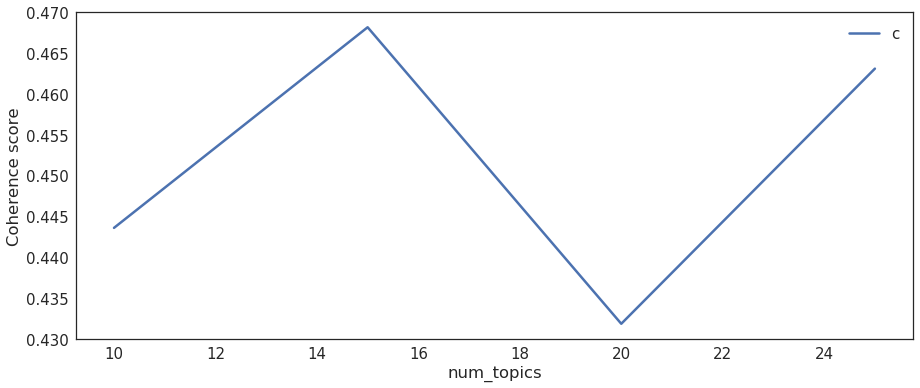

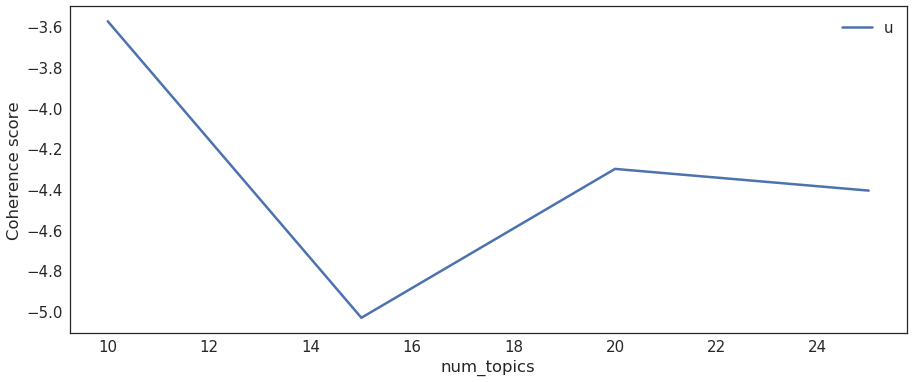

In [43]:
c_v = evaluate_graph(dictionary, corpus, docs, 10, 50, 5)

In [38]:
lm_list

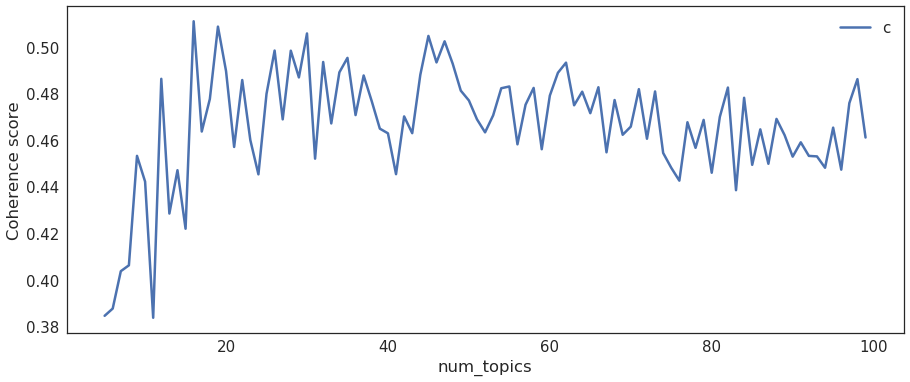

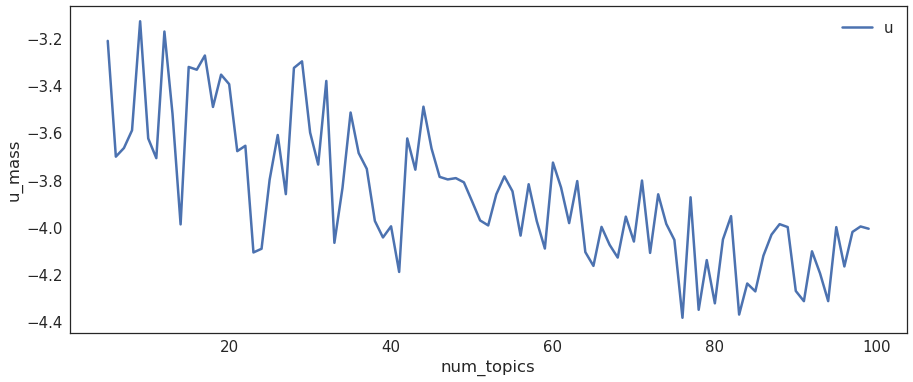

In [54]:
c_v = []
with open('c_v.txt') as inputfile:
    for line in inputfile:
        c_v.append(line.strip().split(','))

# Show graph
    x = range(5, 100, 1)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

u_mass = []
with open('u_mass.txt') as inputfile:
    for line in inputfile:
        u_mass.append(line.strip().split(','))

# Show graph
    x = range(5, 100, 1)
    plt.plot(x, u_mass)
    plt.xlabel("num_topics")
    plt.ylabel("u_mass")
    plt.legend(("u_mass"), loc='best')
    plt.show()

In [64]:
u_mass[11]

['-3.333509103950977']

In [62]:
c_v[11]

['0.5109961212711722']

In [17]:
top_topics = model.top_topics(corpus, topn=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2018-04-18 13:25:21,750 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-04-18 13:25:21,767 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-04-18 13:25:21,789 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-04-18 13:25:21,810 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-04-18 13:25:21,836 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-04-18 13:25:21,861 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-04-18 13:25:21,885 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-04-18 13:25:21,913 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-04-18 13:25:21,943 : INFO : CorpusAccumulator accumulated stats from 9000 documents


Average topic coherence: -4.0719.
[([(0.013515936, 'maanden'),
   (0.013250907, 'panda'),
   (0.012247385, 'gulden'),
   (0.012135609, 'rente'),
   (0.011343648, 'voordeel'),
   (0.010778351, 'geldt'),
   (0.0092515144, 'aanbod'),
   (0.009031035, 'huidige'),
   (0.0089858938, 'betalen'),
   (0.0088824658, 'bedrag'),
   (0.0088395048, 'voorwaarden'),
   (0.0079387687, 'onze'),
   (0.0079268049, 'koopt'),
   (0.0077343774, 'ritmo'),
   (0.0073490273, 'voorraad'),
   (0.0067884908, 'liefst'),
   (0.0059614335, 'strekt'),
   (0.0058324137, 'bijvoorbeeld'),
   (0.0058269259, 'basis'),
   (0.0056991247, 'financiering')],
  -1.8102235841692857),
 ([(0.038442675, 'verstelbare'),
   (0.023016026, 'speciale'),
   (0.020985717, 'glas'),
   (0.019558061, 'bekleding'),
   (0.019520845, 'voordeel'),
   (0.017106067, 'hoogte'),
   (0.017096672, 'astra'),
   (0.014890728, 'bumpers'),
   (0.014254414, 'hoofdsteunen'),
   (0.014222285, 'brede'),
   (0.013485962, 'kleur'),
   (0.013343343, 'rijklaar'),


In [27]:
cm = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
cm_cv = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
print(cm.get_coherence())
print(cm_cv.get_coherence())

2018-04-18 13:33:00,263 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-04-18 13:33:00,279 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-04-18 13:33:00,298 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-04-18 13:33:00,319 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-04-18 13:33:00,345 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-04-18 13:33:00,370 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-04-18 13:33:00,393 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-04-18 13:33:00,419 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-04-18 13:33:00,445 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-04-18 13:33:00,523 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows


-4.0718964602


2018-04-18 13:33:00,733 : INFO : 23 batches submitted to accumulate stats from 1472 documents (-43030 virtual)
2018-04-18 13:33:00,749 : INFO : 26 batches submitted to accumulate stats from 1664 documents (-45439 virtual)
2018-04-18 13:33:00,786 : INFO : 27 batches submitted to accumulate stats from 1728 documents (-44823 virtual)
2018-04-18 13:33:00,792 : INFO : 28 batches submitted to accumulate stats from 1792 documents (-44465 virtual)
2018-04-18 13:33:00,848 : INFO : 33 batches submitted to accumulate stats from 2112 documents (-47345 virtual)
2018-04-18 13:33:00,954 : INFO : 37 batches submitted to accumulate stats from 2368 documents (-48480 virtual)
2018-04-18 13:33:01,037 : INFO : 41 batches submitted to accumulate stats from 2624 documents (-49071 virtual)
2018-04-18 13:33:01,074 : INFO : 42 batches submitted to accumulate stats from 2688 documents (-48629 virtual)
2018-04-18 13:33:01,118 : INFO : 44 batches submitted to accumulate stats from 2816 documents (-48804 virtual)
2

2018-04-18 13:33:04,211 : INFO : 125 batches submitted to accumulate stats from 8000 documents (35266 virtual)
2018-04-18 13:33:04,239 : INFO : 126 batches submitted to accumulate stats from 8064 documents (35903 virtual)
2018-04-18 13:33:04,263 : INFO : 127 batches submitted to accumulate stats from 8128 documents (37732 virtual)
2018-04-18 13:33:04,401 : INFO : 128 batches submitted to accumulate stats from 8192 documents (40557 virtual)
2018-04-18 13:33:04,482 : INFO : 129 batches submitted to accumulate stats from 8256 documents (42863 virtual)
2018-04-18 13:33:04,491 : INFO : 130 batches submitted to accumulate stats from 8320 documents (44086 virtual)
2018-04-18 13:33:04,524 : INFO : 131 batches submitted to accumulate stats from 8384 documents (45968 virtual)
2018-04-18 13:33:04,587 : INFO : 132 batches submitted to accumulate stats from 8448 documents (46726 virtual)
2018-04-18 13:33:04,593 : INFO : 133 batches submitted to accumulate stats from 8512 documents (47637 virtual)
2

0.442429019283


In [45]:
topic_words = []
for i in range(num_topics):
    tt = model.get_topic_terms(i,150)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    lda_words = []
    for topic in topic_words:
        for word in topic:
            if word not in lda_words:
                lda_words.append(word)

In [20]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      12.527753  1        1      -0.083699  0.127857
16     8.271900   1        2      -0.075911  0.062802
17     7.219726   1        3      -0.140376  0.037620
5      6.177741   1        4       0.004092 -0.168094
0      6.125647   1        5      -0.049415  0.120465
15     5.581744   1        6       0.008907  0.035956
2      5.417426   1        7      -0.119678  0.091264
12     5.345255   1        8      -0.129362  0.072818
13     5.256329   1        9      -0.176190 -0.089429
1      4.335997   1        10      0.284303  0.104093
6      4.291181   1        11      0.031803  0.026285
4      4.124372   1        12     -0.036615  0.017602
7      3.744635   1        13      0.070618 -0.378917
18     3.591463   1        14      0.087336  0.129002
14     3.434048   1        15     -0.031123 -0.067095
11     3.332110   1        16      0.113418 -0.070297
8      3.153882   1        17      0.045046 -0.016558
9      2.916956   1        18     -0.133443 -0.103167
19     2.855665   1        19      0.222726  0.025475
10     2.296170   1        20      0.107563  0.042318, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
1585  Default  3207.000000  peugeot             3207.000000  30.0000  30.0000
7032  Default  2688.000000  mazda               2688.000000  29.0000  29.0000
427   Default  2310.000000  telefoon            2310.000000  28.0000  28.0000
314   Default  1597.000000  simca               1597.000000  27.0000  27.0000
1388  Default  1398.000000  alfa                1398.000000  26.0000  26.0000
6207  Default  1419.000000  toyota              1419.000000  25.0000  25.0000
1179  Default  1496.000000  mercedes            1496.000000  24.0000  24.0000
5387  Default  1469.000000  excl                1469.000000  23.0000  23.0000
1098  Default  1177.000000  autobedrijf         1177.000000  22.0000  22.0000
492   Default  1163.000000  garage              1163.000000  21.0000  21.0000
3332  Default  1097.000000  escort              1097.000000  20.0000  20.0000
2356  Default  1319.000000  verstelbare         1319.000000  19.0000  19.0000
5757  Default  1185.000000  honda               1185.000000  18.0000  18.0000
40    Default  1016.000000  chrysler            1016.000000  17.0000  17.0000
415   Default  958.000000   automobielbedrijf   958.000000   16.0000  16.0000
337   Default  1639.000000  sedan               1639.000000  15.0000  15.0000
1446  Default  986.000000   volkswagen          986.000000   14.0000  14.0000
5630  Default  969.000000   kadett              969.000000   13.0000  13.0000
2302  Default  1360.000000  audi                1360.000000  12.0000  12.0000
4497  Default  947.000000   binnenuit           947.000000   11.0000  11.0000
8602  Default  746.000000   ohra                746.000000   10.0000  10.0000
1710  Default  690.000000   gids                690.000000   9.0000   9.0000 
2384  Default  775.000000   getint              775.000000   8.0000   8.0000 
6832  Default  789.000000   corolla             789.000000   7.0000   7.0000 
2468  Default  995.000000   financiering        995.000000   6.0000   6.0000 
978   Default  1357.000000  voordeel            1357.000000  5.0000   5.0000 
6211  Default  665.000000   hertz               665.000000   4.0000   4.0000 
2863  Default  818.000000   stuurbekrachtiging  818.000000   3.0000   3.0000 
523   Default  991.000000   glas                991.000000   2.0000   2.0000 
1180  Default  718.000000   mercedesbenz        718.000000   1.0000   1.0000 
...       ...         ...    ...                       ...      ...      ... 
7945  Topic20  47.068243    alfasud             47.400456    3.7669  -5.7798 
4786  Topic20  39.927845    twijfel             40.211942    3.7668  -5.9443 
8861  Topic20  46.671606    munsterhuis

## NMF

In [55]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

n_features = 10000
n_components = 15
n_top_words = 1000
stop_word = set(stopwords.words('dutch'))

def nmf_topic_modeling(docs, n_top_words):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5, stop_words=stop_word)
    dtm = tfidf_vectorizer.fit_transform(docs)
    vocab = tfidf_vectorizer.get_feature_names()
    print("number of words: {}".format(len(vocab)))
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd', verbose=0, max_iter=500)
    doctopic = nmf.fit_transform(dtm)
    topic_words = []
    topic_summaries = []
    for topic in nmf.components_:
        word_idx = np.argsort(topic)[::-1][0:n_top_words]
        topic_words.append([vocab[i] for i in word_idx])
    for t in range(len(topic_words)):
        print("Topic {}: {}".format(t, ' '.join(topic_words[t][:n_top_words])))
        topic_summaries.append("Topic {}: {}".format(t, ' '.join(topic_words[t][:n_top_words])))
    return doctopic, topic_words, topic_summaries

In [58]:
docs = np.array(car_df.ocr_clean)
doctopic, topic_words, topic_summaries = nmf_topic_modeling(docs, 150)

number of words: 16343
Topic 0: ford escort garantie fiesta dealer extra bravo taunus informeren credit deskundig official vlotte financiering gunstige orion sierra voordelen voordelige leasing adviesprijs vraag prijswijzigingen voorwaarden fabriek jaar cortina laser amsterdam binnenuit scorpio transit fords voorbehouden granada doorroesten advertentie standaard importeur automobiel nieuwe capri afleveringskosten consul liter vanaf anglia deal biedt wagon verbruikscijfers motoren adviesprijzen nieuw mondeo levenslange gegarandeerd festival deurs reparaties weet luxe jubileum proefrit airbag wagen beweeg station tapijt amerikaanse mcphersonvering zephyr pack rijden nederlandsche levenslang geeft europa voorwielen ledere wieldeksels geld ecenorm prijs motor ghia chte gel graag keuze dezelfde aeroflowventilatie prijzen maat kontant slechts sportieve stad konstant staat diesel alle safety remsysteem linnaeusstraat nder zesduizend beroemde races kleinewagenprijs genoemde radio voorbehou pkm

In [60]:
nmf_words = []
for topic in topic_words:
    for word in topic:
        if word not in nmf_words:
            nmf_words.append(word)         

# Detecting Bursts
### Technique from: https://github.com/nmarinsek/burst_analysis/blob/master/fMRIarticle_bursts.ipynb

In [47]:
time_frame = ['publication_year', 'publication_month']
#create dataframe with word proportions
def word_proportions(df, word_list):
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)], axis=1) \
                               .groupby(by=time_frame).sum().reset_index(drop=True)
        if np.mod(i, 100)==0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r

In [ ]:
def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2  #resolution of state jumps; higher s --> fewer but stronger bursts
    gam = 0.5 #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d) #number of timepoints
    smooth_win = 5
    
    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])
    
    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)
        
        #find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win)
        
        #enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)
        
        #find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)
        
        #add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)
        
        #print a progress report every 100 words
        if np.mod(i,100)==0:
            print('total words', len(word_list), 'word',i,'complete')
    
    return all_bursts.sort_values(by='weight', ascending=False)

In [62]:
#all_r_avg_distinct = word_proportions(ads_df, avg_distinctive)
#all_rchi_words = word_proportions(ads_df, chi_words)
#all_r_tf_idf_words = word_proportions(ads_df, tf_idf_words)
all_nmf_words = word_proportions(car_df, nmf_words)
#all_lda_words = word_proportions(car_df, lda_words)

total words 1501 word 0 complete
total words 1501 word 100 complete
total words 1501 word 200 complete
total words 1501 word 300 complete
total words 1501 word 400 complete
total words 1501 word 500 complete
total words 1501 word 600 complete
total words 1501 word 700 complete
total words 1501 word 800 complete
total words 1501 word 900 complete
total words 1501 word 1000 complete
total words 1501 word 1100 complete
total words 1501 word 1200 complete
total words 1501 word 1300 complete
total words 1501 word 1400 complete
total words 1501 word 1500 complete


In [63]:
#all_r_unique_words.to_pickle('all_unique_words.pkl')
#all_rchi_words.to_pickle('all_r_chi-words.pkl')
#all_r_tf_idf_words.to_pickle('all_r_tf_idf_words.pkl')
#all_lda_words.to_pickle('all_r_lda_words.pkl')
#all_nmf_words.to_pickle('all_r_nmf_words.pkl')

In [ ]:
bursts_nmf = find_bursts(d, all_nmf_words, nmf_words)
bursts_lda = find_bursts(d, all_lda_words, lda_words)
bursts_unique = find_bursts(d, all_r_avg_distinct, unique_words)
bursts_chi = find_bursts(d, all_rchi_words, chi_words)
bursts_tfidf = find_bursts(d, all_r_tf_idf_words, tf_idf_words)

# Visualize bursts

In [67]:
# load pickles of words

unique_words = pd.read_pickle('all_unique_words.pkl')
chi_words = pd.read_pickle('all_r_chi-words.pkl')
tf_idf_words = pd.read_pickle('all_r_tf_idf_words.pkl')
lda_words = pd.read_pickle('all_r_lda_words.pkl')
nmf_words = pd.read_pickle('all_r_nmf_words.pkl')

In [68]:
# load pickles of bursts

bursts_unique_words = pd.read_pickle('burst_unique.pkl')
bursts_chi_words = pd.read_pickle('burst_chi.pkl')
bursts_tf_idf_words = pd.read_pickle('burst_tfidf.pkl')
bursts_lda_words = pd.read_pickle('burst_lda.pkl')
bursts_nmf_words = pd.read_pickle('burst_nmf.pkl')

In [65]:
#bursts_chi.to_pickle('burst_chi.pkl')
#bursts_tfidf.to_pickle('burst_tfidf.pkl')
#bursts_lda.to_pickle('burst_lda.pkl')
#bursts_nmf.to_pickle('burst_nmf.pkl')

In [73]:
def visualize_bursts(n_bursts, bursts, r, title):
    n = len(d) 
    top_bursts = bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]
    #sort bursts by end date
    sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
    #for burst that end at the last timepoint, sort by start
    last_timepoint = np.max(sorted_bursts['end'])
    sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
    heatmap_data = r.loc[:,set(sorted_bursts['label'])]
    
    #find the baseline proportions sum(r)/sum(d) for each label
    baseline_p = heatmap_data.sum(axis=0) / d.sum()

    #convert r values into proportions at each timepoint
    heatmap_data = heatmap_data.apply(lambda x: x/d)

    #sort the rows according to the order used in the timeline
    order = sorted_bursts['label'].drop_duplicates(keep='last').values
    
    #transpose data and reindex the data according to the sorted word order
    heatmap_data = heatmap_data.T.reindex(order)

    #optional: demean proportions
    #heatmap_data = heatmap_data - heatmap_data.mean(axis=1)

    #optional: convert proportions into multiples of the baseline proportion
    heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

    #smooth proportions with the same smoothing window used in burst detection
    smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

    #create the heatmap
    plt.figure(figsize=(10,40))
    ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
    plt.title('Normalized proportions of "bursting" ' + title + ' words over time')
    plt.xticks(range(0,n,24), range(1945,1995,2), rotation='vertical')

    #create boxes around bursting periods
    for index, burst in sorted_bursts.iterrows():
        
        #define outline positions
        y = smoothed_heatmap_data.index.get_loc(burst['label'])
        y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
        xstart = burst['begin'] 
        width = burst['end'] - burst['begin'] + 1
    
        #draw rectangle
        ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))
    plt.savefig(title + "_heatmap.png", bbox_inches="tight", dpi=300)

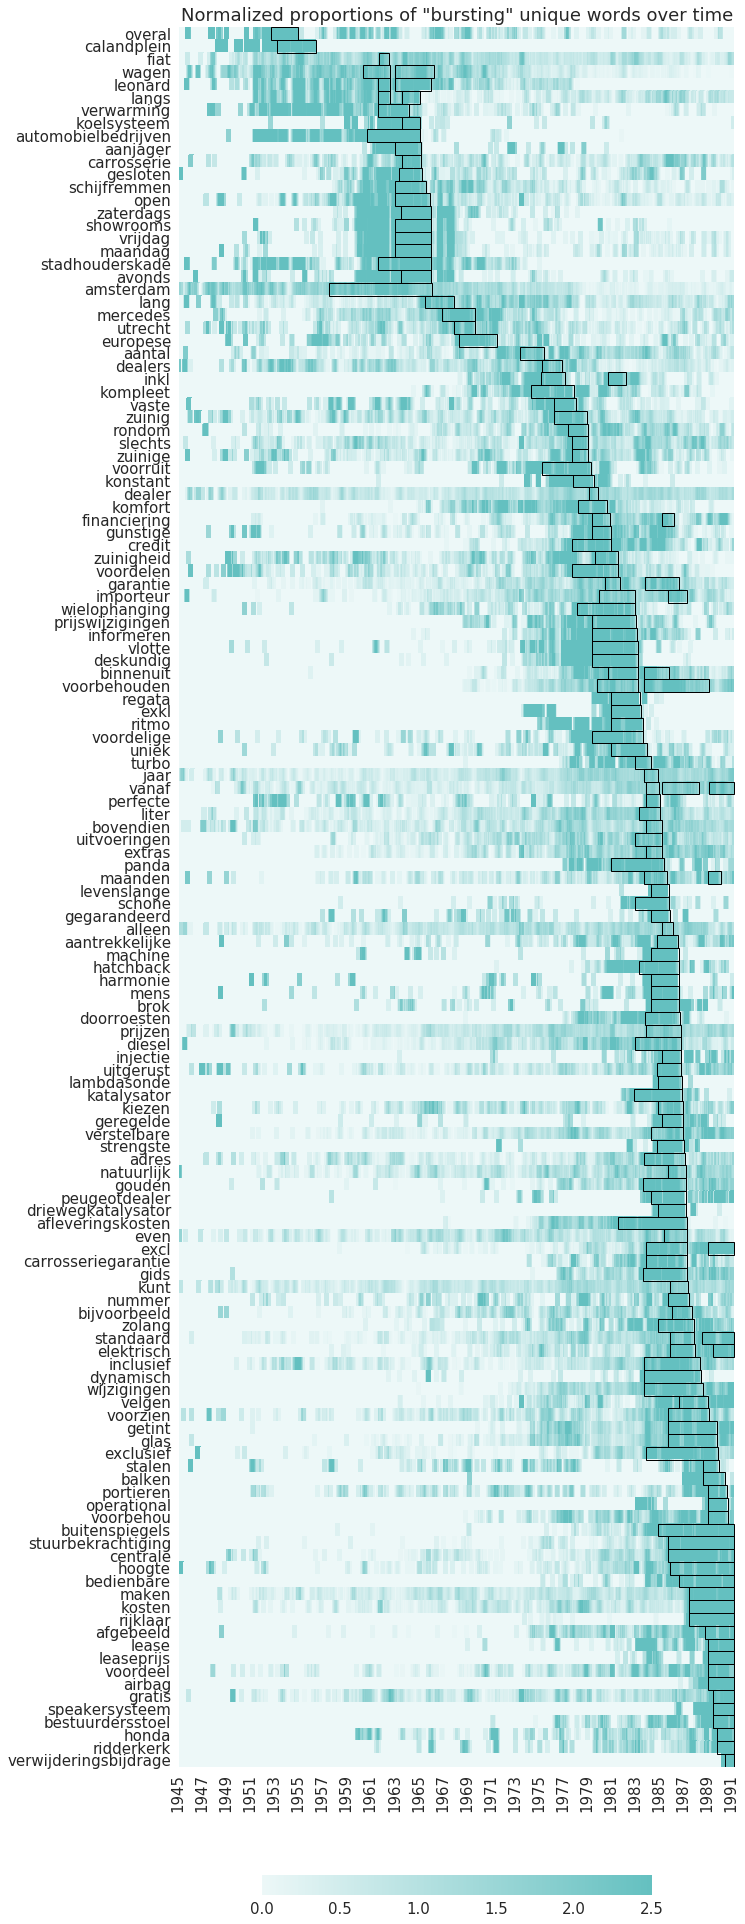

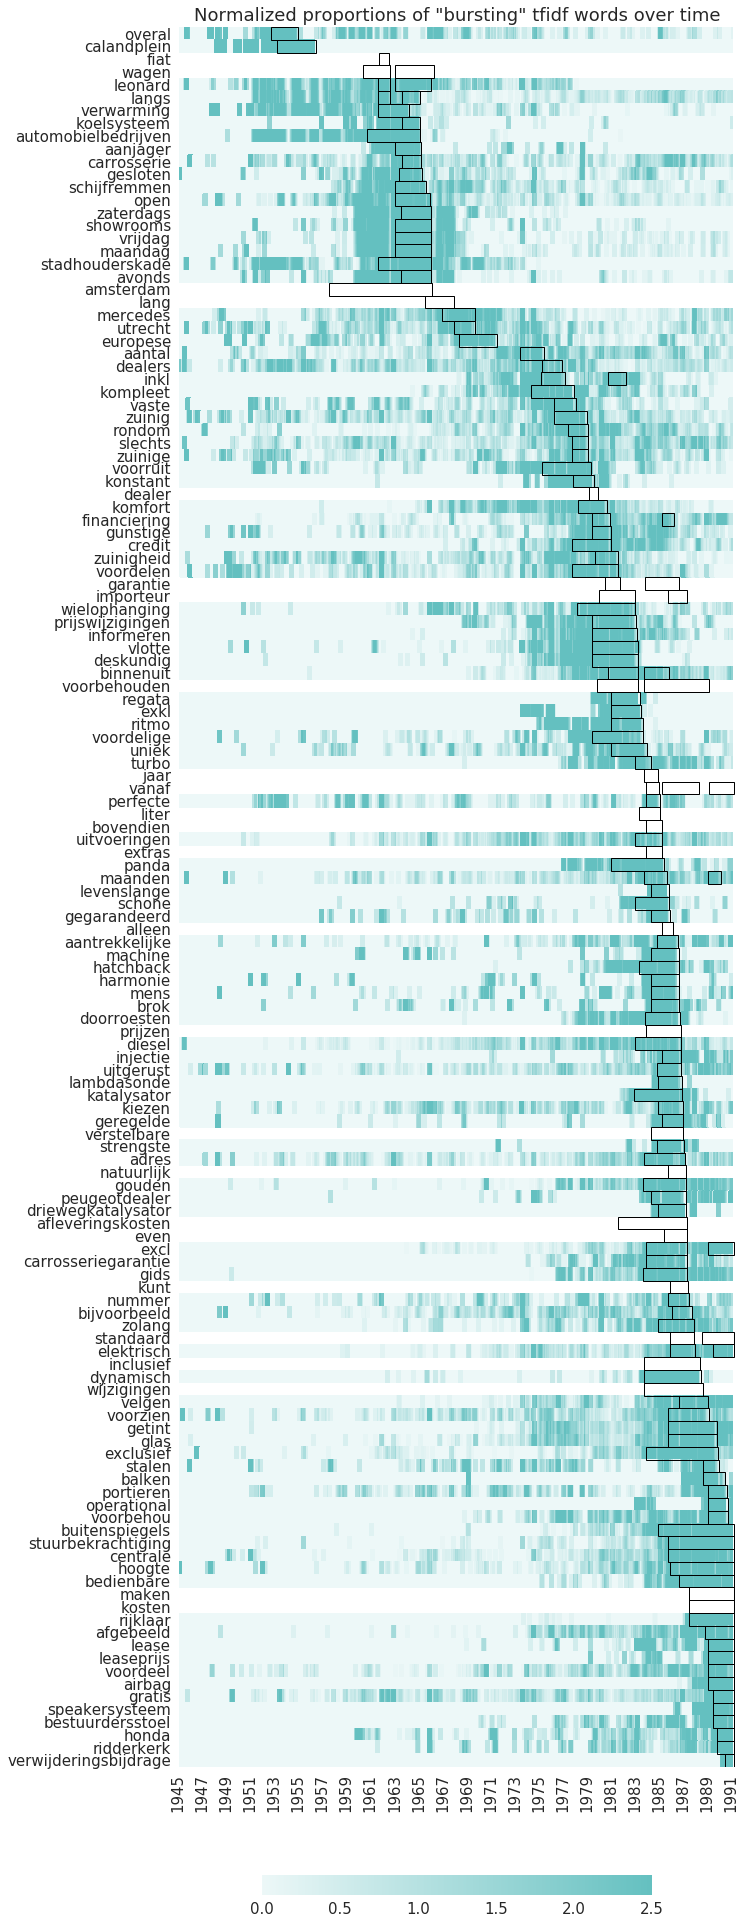

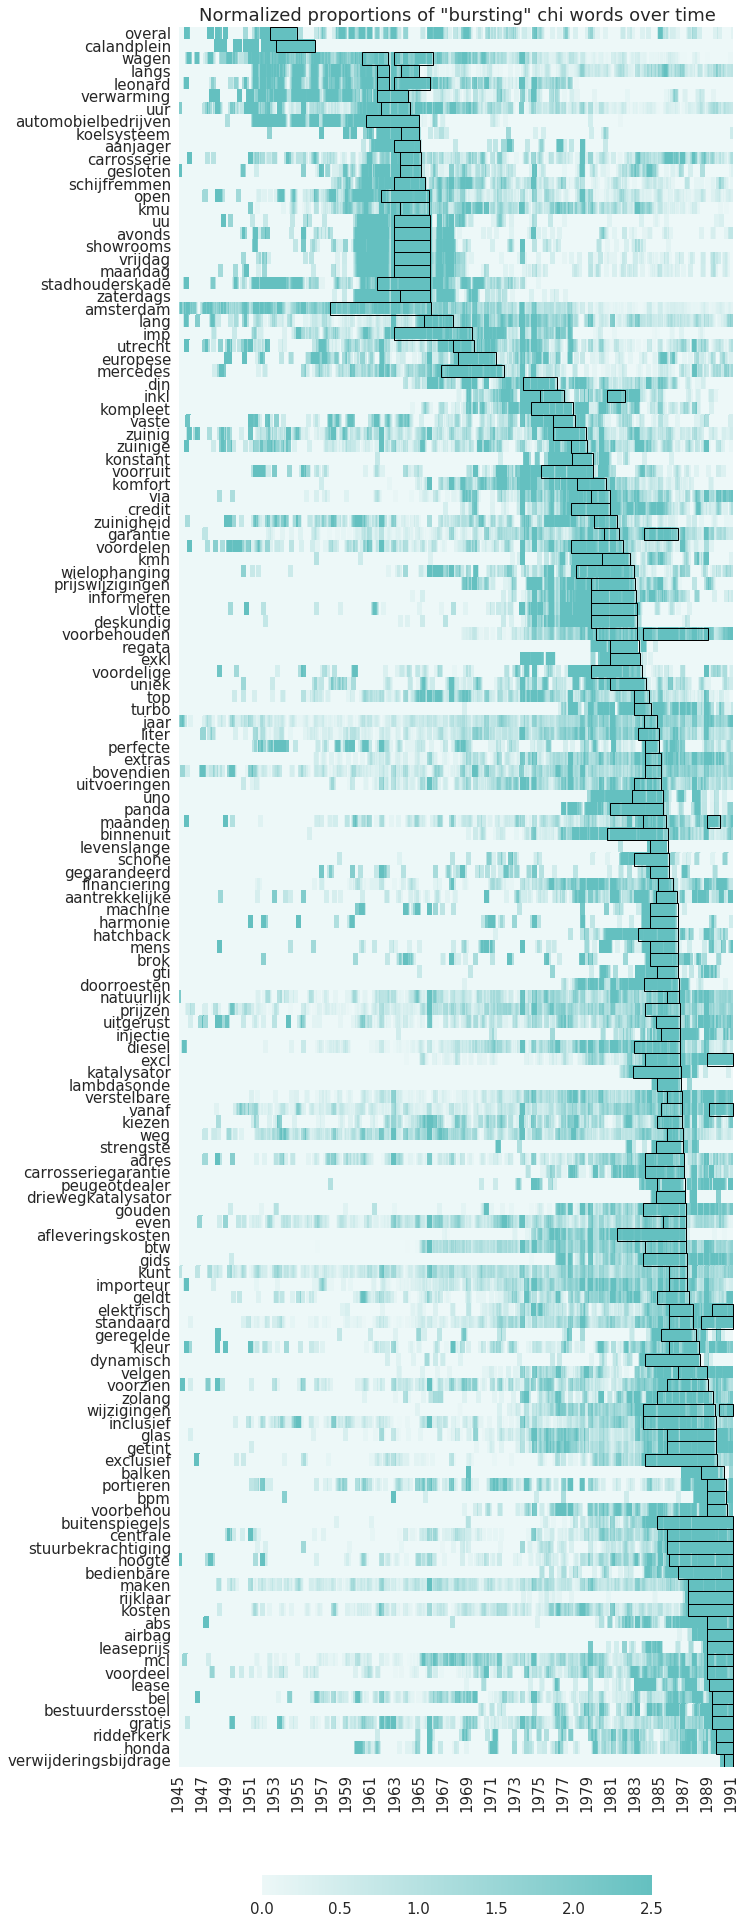

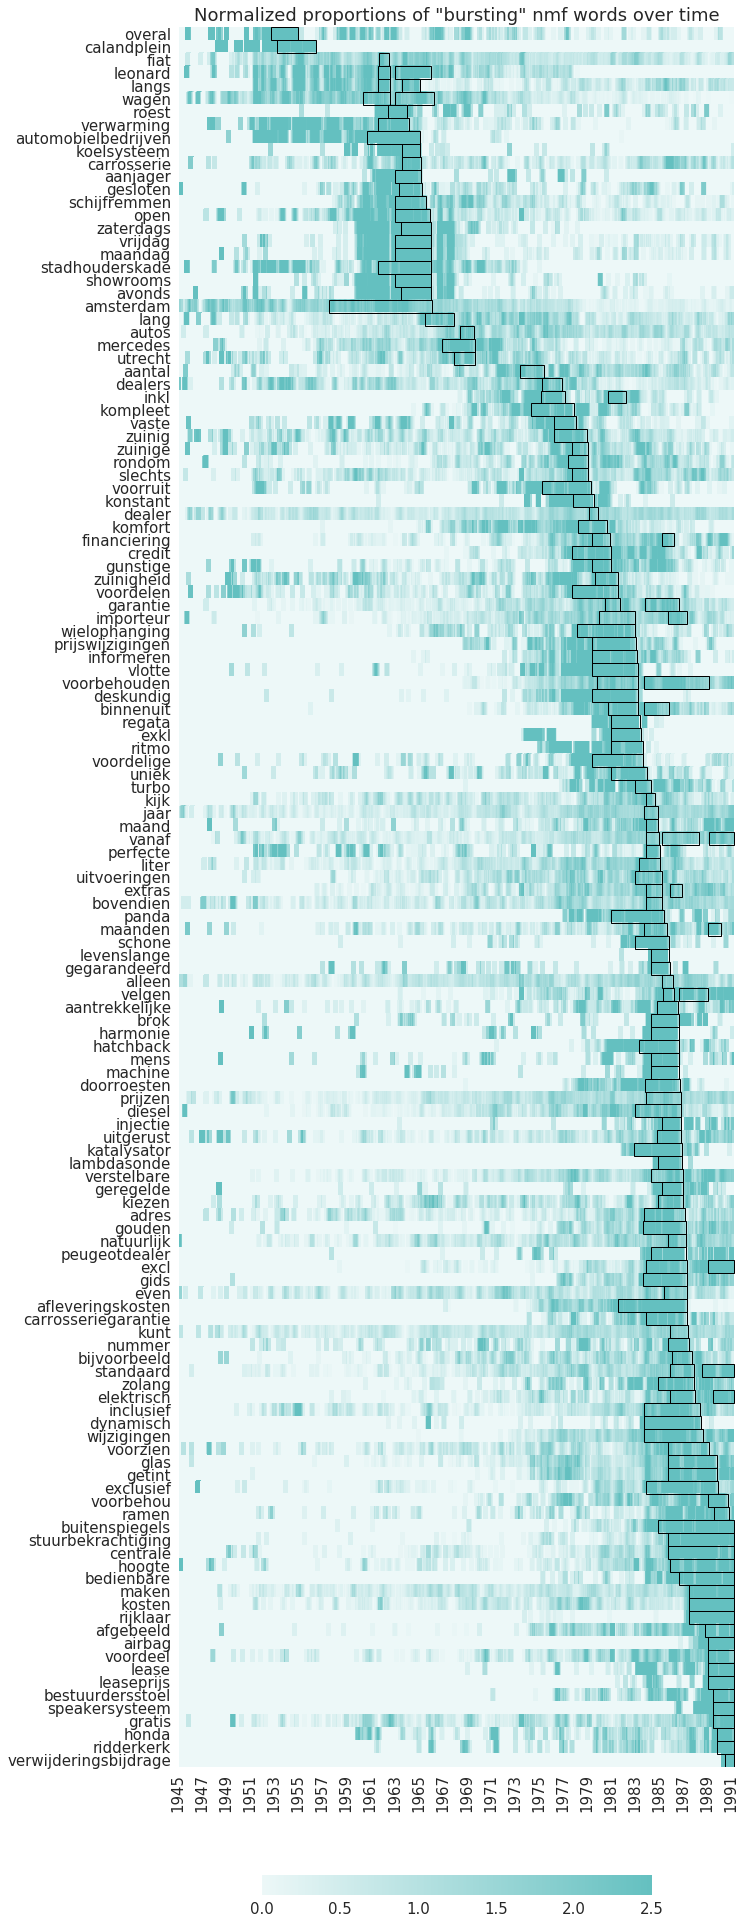

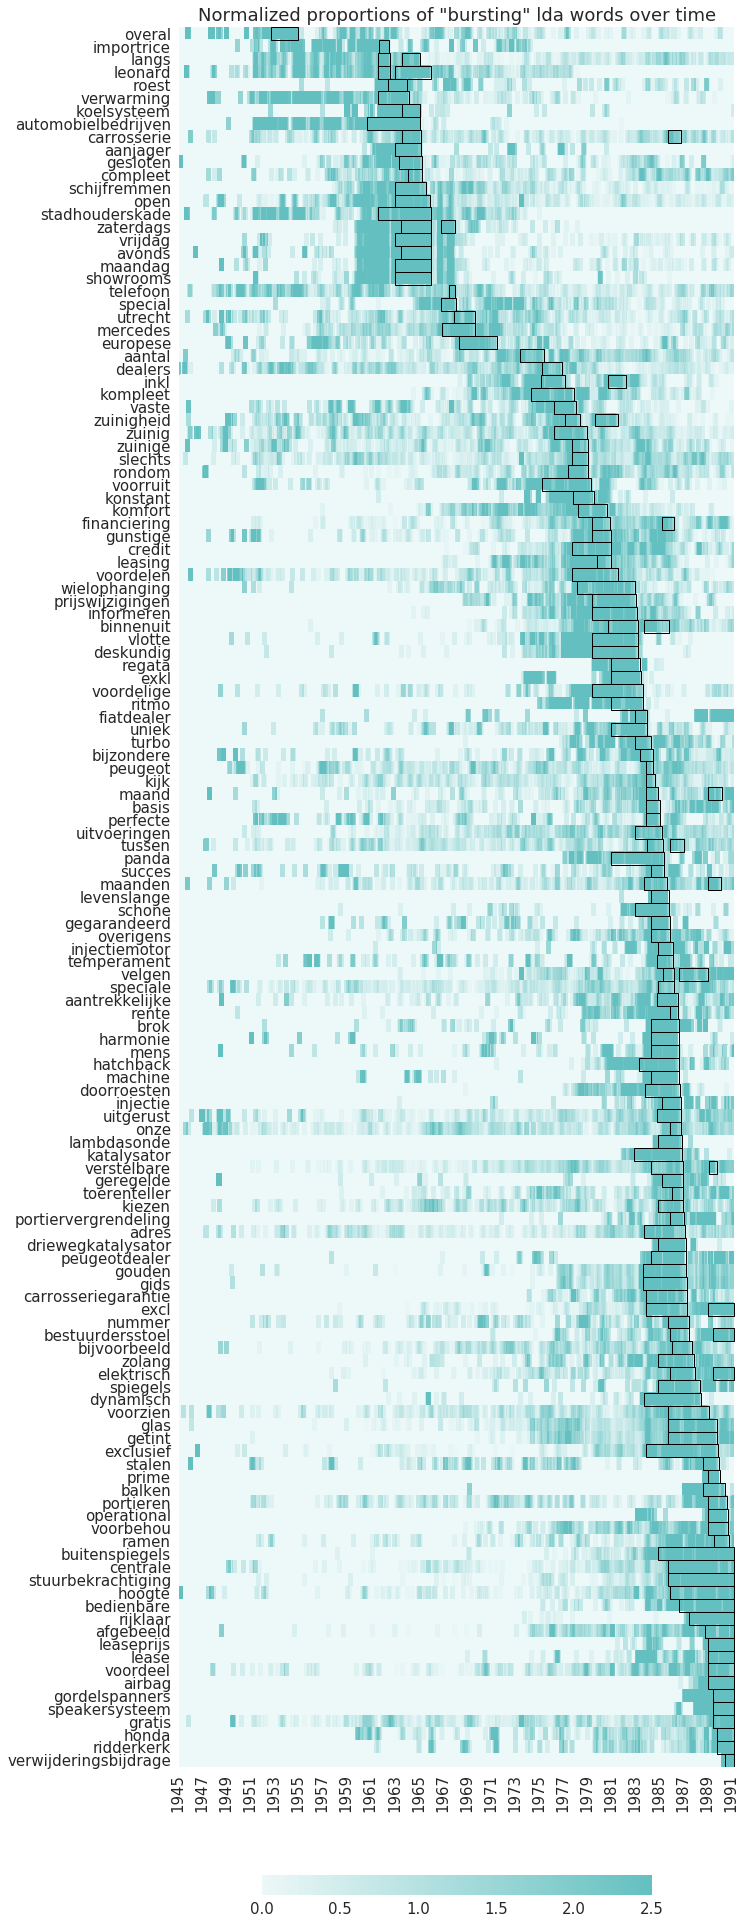

In [74]:
visualize_bursts(150, bursts_unique_words, unique_words, 'unique')
visualize_bursts(150, bursts_unique_words, tf_idf_words, 'tfidf')
visualize_bursts(150, bursts_chi_words, chi_words, 'chi')
visualize_bursts(150, bursts_nmf_words, nmf_words, 'nmf')
visualize_bursts(150, bursts_lda_words, lda_words, 'lda')

In [69]:
bursts_unique_words

,begin,end,label,weight
139,151,253,amsterdam,384.854
361,439,507,afleveringskosten,318.644
299,510,554,maken,282.956
269,465,523,wijzigingen,270.525
404,510,554,kosten,269.138
505,510,554,rijklaar,252.091
110,465,529,voorbehouden,236.054
168,467,538,exclusief,208.195
340,189,241,automobielbedrijven,175.829
127,465,520,inclusief,170.791
